In [1]:
import numpy as np
import pandas as pd
import plotting_utils as pu
import sa_city_utils as sacu
import gev_utils as gevu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
from utils import gev_metric_ids

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [12]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

## Get city data

In [3]:
# %%time
# # Original grids
# grid = "original"
# proj_slice = "2050-2100"
# hist_slice = "1950-2014"
# stationary = True
# fit_method = "lmom"
# cols_to_keep = ["20yr_return_level", "50yr_return_level", "100yr_return_level", "200yr_return_level"]
# col_identifier = "return_levels"

# for metric_id in gev_metric_ids:
#     sacu.store_all_cities(
#         metric_id=metric_id,
#         grid=grid,
#         regrid_method=None,
#         proj_slice=proj_slice,
#         hist_slice=hist_slice,
#         stationary=stationary,
#         fit_method=fit_method,
#         cols_to_keep=cols_to_keep,
#         col_identifier=col_identifier,
#         city_list=city_list,
#     )

In [4]:
# %%time
# # LOCA2 grid
# grid = "LOCA2"
# regrid_method = "nearest"
# proj_slice = "2050-2100"
# hist_slice = "1950-2014"
# stationary = True
# fit_method = "lmom"
# cols_to_keep = ["20yr_return_level", "50yr_return_level", "100yr_return_level", "200yr_return_level"]
# col_identifier = "return_levels"

# for metric_id in gev_metric_ids:
#     sacu.store_all_cities(
#         metric_id=metric_id,
#         grid=grid,
#         regrid_method=regrid_method,
#         proj_slice=proj_slice,
#         hist_slice=hist_slice,
#         stationary=stationary,
#         fit_method=fit_method,
#         cols_to_keep=cols_to_keep,
#         col_identifier=col_identifier,
#         city_list=city_list,
#     )

## Plots

In [2]:
city = 'denver'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = 'stat'

In [3]:
metric_id = 'max_tasmax'

df = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}.csv')

In [4]:
df_uc = sacu.calculate_df_uc(df, plot_col, True)

NameError: name 'plot_col' is not defined

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey='row')
axs = axs.flatten()

uc_names = ['Scenario',
            'Response', 
            'IV',
            'Downscaling',
            'GEV fit']

fig.suptitle('Denver \n (2050-2100 change from historical)', fontweight='bold')

idx = 0
for metric_id in ['min_tasmin', 'max_tasmax', 'max_pr']:
    df = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}.csv')
    df = df[df['gcm'] != 'TaiESM1']
    for return_level in [10, 50, 100]:
        ax = axs[idx]
        plot_col = f"{return_level}yr_return_level_change"
        df_uc = sacu.calculate_df_uc(df, plot_col, True)

        df_uc[df_uc['uncertainty_type'] != 'ssp_uc'].plot.bar(x='uncertainty_type', y='mean', yerr='std', ax=ax, legend=False)

        # Tidy
        ax.set_xticklabels(uc_names, rotation=45)
        ax.set_xlabel('')
        ax.set_title(f"{metric_id} {return_level}yr")
        ax.grid(alpha=0.2, zorder=3)
        idx += 1

plt.show()

In [5]:
from utils import gard_gcms

In [6]:
metric_id = 'max_tasmax'

df = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}.csv')

df = df[df['gcm'] != 'TaiESM1']

In [7]:
df = df.set_index(['ensemble', 'gcm', 'member', 'ssp'])

In [60]:
def plot_jagged_scatter(df, plot_col, position, color, ax, jitter_amount=0.1, limits=None, s=20, alpha=0.8):
    # Filter data below limits if desired
    if limits is not None:
        data = df[(df[plot_col] < limits[1]) & (df[plot_col] > limits[0])]
    else:
        data = df.copy()
    
    # Take only the central values
    data = data[data["quantile"] == "main"]
    
    # Random offsets for y-axis
    y_offsets = np.clip(np.random.normal(loc=0., scale=jitter_amount, size=len(data)), -0.4, 0.4)
    y_values = [position + offset for offset in y_offsets]
    
    # Create jagged scatter plot
    ax.scatter(
        x=data[plot_col],
        y=y_values,
        c='white',
        # c=color,
        edgecolor=color,
        s=s,
        alpha=alpha,
        zorder=5,
    )

In [61]:
def plot_conf_intvs(df, plot_col, positions, color, ax, limits=None, lw=1.5, s=20, alpha=1):
    # Filter data below limits if desired
    if limits is not None:
        data = df[(df[plot_col] < limits[1]) & (df[plot_col] > limits[0])]
    else:
        data = df.copy()

    # Point for median
    ax.scatter(
        x=[data[data["quantile"] == "main"][plot_col].values[0]],
        y=positions,
        c=color,
        s=s,
        zorder=6,
    )

    # Line for 95% CI
    ax.plot(
        [
            data[data["quantile"] == "p025"][plot_col].values[0],
            data[data["quantile"] == "p975"][plot_col].values[0],
        ],
        [positions, positions],
        color=color,
        linewidth=lw,
        zorder=6,
        alpha=alpha,
    )

In [62]:
import matplotlib.transforms as transforms

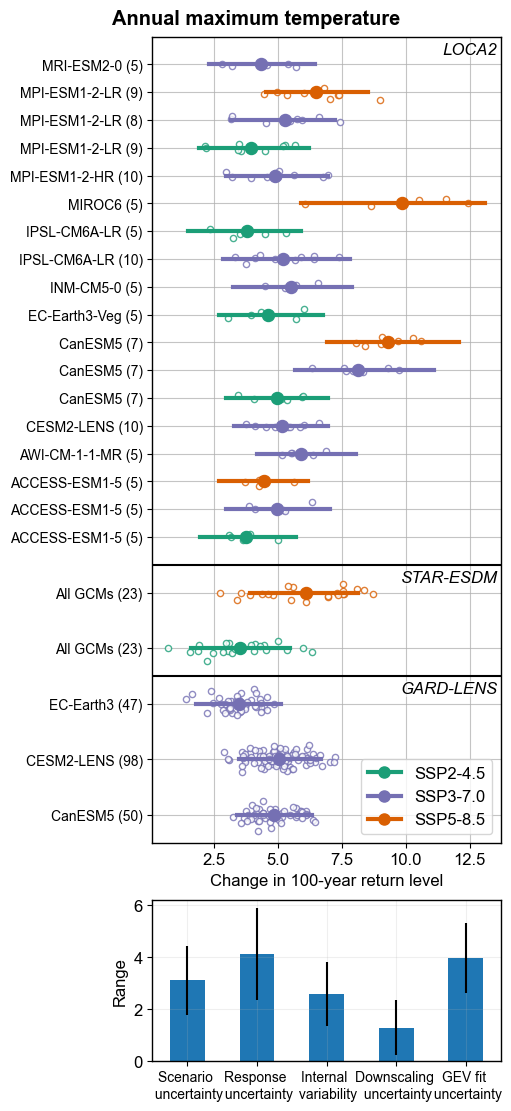

In [74]:
plot_col = '100yr_return_level_change'
n_min_members = 5

fig, axs = plt.subplots(2, 1, figsize=(5,11), height_ratios=[5,1], layout='constrained')

fig.suptitle('Annual maximum temperature', fontweight='bold')

############################
# UC
############################
uc_names = ['Scenario \n uncertainty',
            'Response \n uncertainty', 
            'Internal \n variability',
            'Downscaling \n uncertainty',
            'GEV fit \n uncertainty']

ax=axs[1]
df_uc = sacu.calculate_df_uc(df, plot_col, True)

df_uc[df_uc['uncertainty_type'] != 'ssp_uc'].plot.bar(x='uncertainty_type', y='mean', yerr='std', ax=ax, legend=False)

# Tidy
ax.set_xticklabels(uc_names, rotation=0, fontsize=10)
ax.set_ylabel('Range')
ax.set_xlabel('')
ax.grid(alpha=0.2, zorder=3)

############################
# Boxplots
############################
ax=axs[0]
trans = transforms.blended_transform_factory(
    ax.transAxes,  # x in axis coordinates (0 to 1)
    ax.transData    # y in data coordinates
)

idy = 0
label_names = []
label_idy = []

# GARD-LENS
ensemble = 'GARD-LENS'
for gcm in gard_gcms:
    df_sel = df.loc[ensemble, gcm, :, :]
    df_sel_grouped = df_sel.groupby('quantile').mean(numeric_only=True).reset_index()
    plot_conf_intvs(df_sel_grouped, plot_col, [idy], pu.ssp_colors['ssp370'], ax, s=75, lw=3)
    plot_jagged_scatter(df_sel, plot_col, [idy], pu.ssp_colors['ssp370'], ax)
    label_names.append(f"{gcm} ({len(df_sel)//3})")
    label_idy.append(idy)
    idy += 1

ax.axhline(idy-0.5, color='black')
ax.text(0.99, idy-0.6, 'GARD-LENS', transform=trans, 
        fontstyle='italic', fontweight='bold',
        bbox={'facecolor': 'white', 'edgecolor': 'none', 'alpha': 0.5, 'pad':0.1},
        verticalalignment='top', horizontalalignment='right')

# STAR-ESDM
ensemble = 'STAR-ESDM'
for ssp in df.loc[ensemble].index.unique(level='ssp'):
    df_sel = df.loc[ensemble, :, :, ssp]
    df_sel_grouped = df_sel.groupby('quantile').mean(numeric_only=True).reset_index()
    plot_conf_intvs(df_sel_grouped, plot_col, [idy], pu.ssp_colors[ssp], ax, s=75, lw=3)
    plot_jagged_scatter(df_sel, plot_col, [idy], pu.ssp_colors[ssp], ax, jitter_amount=0.075)
    label_names.append(f"All GCMs ({len(df_sel)//3})")
    label_idy.append(idy)
    idy += 1

ax.axhline(idy-0.5, color='black')
ax.text(0.99, idy-0.6, 'STAR-ESDM', transform=trans, 
        fontstyle='italic', fontweight='bold',
        bbox={'facecolor': 'white', 'edgecolor': 'none', 'alpha': 0.5, 'pad':0.1},
        verticalalignment='top', horizontalalignment='right')

# LOCA2
ensemble = 'LOCA2'
for gcm in df.loc[ensemble].index.unique(level='gcm'):
    for ssp in df.loc[ensemble, gcm].index.unique(level='ssp'):
        if len(df.loc[ensemble, gcm, :, ssp].index.unique(level='member')) >= n_min_members:
            df_sel = df.loc[ensemble, gcm, :, ssp]
            df_sel_grouped = df_sel.groupby('quantile').mean(numeric_only=True).reset_index()
            plot_conf_intvs(df_sel_grouped, plot_col, [idy], pu.ssp_colors[ssp], ax, s=75, lw=3)
            plot_jagged_scatter(df_sel, plot_col, [idy], pu.ssp_colors[ssp], ax, jitter_amount=0.05)
            label_names.append(f"{gcm} ({len(df_sel)//3})")
            label_idy.append(idy)
            idy += 0.5

ax.text(0.99, idy-0.1, 'LOCA2', transform=trans, 
        fontstyle='italic', fontweight='bold',
        bbox={'facecolor': 'white', 'edgecolor': 'none', 'alpha': 0.5, 'pad':0.1},
        verticalalignment='top', horizontalalignment='right')

ax.set_ylim([-0.5, idy])
ax.set_yticks(label_idy, label_names, fontsize=10)
ax.grid(alpha=0.75)

ax.set_xlabel('Change in 100-year return level')

# Legend
legend_elements = [Line2D([0], [0],
                          marker="o",
                          color=pu.ssp_colors[ssp],
                          markerfacecolor=pu.ssp_colors[ssp],
                          markersize=8, 
                          lw=3, label=pu.ssp_labels[ssp]) 
                   for ssp in pu.ssp_colors.keys()]
ax.legend(handles=legend_elements, loc='lower right')

plt.show()

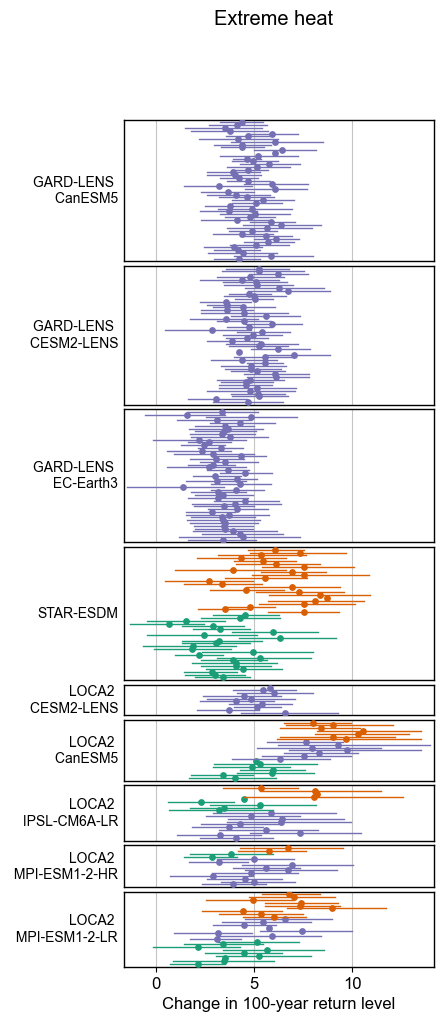

In [55]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1

plot_col = '100yr_return_level_change'
n_min_members = 5

# Get all unique ensembles
ensembles = ['GARD-LENS', 'STAR-ESDM', 'LOCA2']

# Count total number of subplots needed
subplot_count = 0
subplot_heights = []

# GARD-LENS
for gcm in gard_gcms:
    subplot_count += 1
    combos = df.loc['GARD-LENS', gcm].index.unique()
    # Skip half of CESM
    if gcm == "CESM2-LENS":
        combos = combos[::2]
    subplot_heights.append(len(combos) + 1)  # +1 for spacing

# STAR-ESDM
subplot_count += 1
subplot_heights.append(len(combos) + 1)  # +1 for spacing
    
# LOCA2
for gcm in df.loc['LOCA2'].index.unique(level='gcm'):
    if len(df.loc['LOCA2', gcm, :, :].index.unique(level='member')) > n_min_members:
        subplot_count += 1
        num_members = 0
        for ssp in df.loc['LOCA2', gcm].index.unique(level='ssp'):
            num_members += len(df.loc['LOCA2', gcm, :, ssp].index.unique())
        subplot_heights.append(num_members + 1)  # +1 for spacing

# Create figure with custom GridSpec
fig = plt.figure(figsize=(4, 11))
gs = GridSpec(subplot_count, 1, height_ratios=subplot_heights, hspace=0.05)

# Get the overall x limits to keep consistent across subplots
rows_to_plot = df[df['quantile'] == 'main'].groupby(['ensemble', 'gcm', 'ssp'])[plot_col].count() > n_min_members
filtered_df = df.reset_index().set_index(['ensemble', 'gcm', 'ssp']).loc[rows_to_plot]
x_min = filtered_df[plot_col].min() - 0.2
x_max = filtered_df[plot_col].max() + 0.2

subplot_idx = 0
axes = []

# GARD-LENS
ensemble = 'GARD-LENS'
for gcm in gard_gcms:
    ax = fig.add_subplot(gs[subplot_idx])
    axes.append(ax)
    
    idy = 0
    combos = df.loc[ensemble, gcm].index.unique()
    # Skip half of CESM
    if gcm == "CESM2-LENS":
        combos = combos[::2]
    for combo in combos:
        member, ssp = combo
        df_sel = df.loc[ensemble, gcm, member, ssp]
        plot_conf_intvs(df_sel, plot_col, [idy], pu.ssp_colors[ssp], ax, s=15, lw=1)
        idy += 1
    
    # Set axes properties
    ax.set_ylim([-1, idy])
    ax.set_xlim([x_min, x_max])
    ax.set_yticks([])
    ax.set_ylabel(f"{ensemble} \n {gcm}", fontsize=10, rotation=0, horizontalalignment='right', verticalalignment='center')
    ax.tick_params(axis='y', labelrotation=45)
    ax.set_xlabel('')
    ax.grid(alpha=0.75, axis='x')
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    
    subplot_idx += 1

# STAR-ESDM
ensemble = 'STAR-ESDM'
ax = fig.add_subplot(gs[subplot_idx])
axes.append(ax)
idy = 0
for ssp in df.loc[ensemble].index.unique(level='ssp'):
    combos = df.loc[ensemble, :, :, ssp].index.unique()
    for combo in combos:
        gcm, member = combo
        df_sel = df.loc[ensemble, gcm, member, ssp]
        plot_conf_intvs(df_sel, plot_col, [idy], pu.ssp_colors[ssp], ax, s=15, lw=1)
        idy += 1
            
# Set axes properties
ax.set_ylim([-1, idy])
ax.set_xlim([x_min, x_max])
ax.set_yticks([])
ax.set_ylabel(f"{ensemble}", fontsize=10, rotation=0, horizontalalignment='right', verticalalignment='center')
ax.tick_params(axis='y', labelrotation=45)
ax.grid(alpha=0.75, axis='x')
ax.set_xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

subplot_idx += 1

# LOCA2
ensemble = 'LOCA2'
for gcm in df.loc[ensemble].index.unique(level='gcm'):
    if len(df.loc[ensemble, gcm, :, :].index.unique(level='member')) > n_min_members:
        ax = fig.add_subplot(gs[subplot_idx])
        axes.append(ax)
        
        idy = 0
        for ssp in df.loc[ensemble, gcm].index.unique(level='ssp'):
            combos = df.loc[ensemble, gcm, :, ssp].index.unique()
            for combo in combos:
                member = combo
                df_sel = df.loc[ensemble, gcm, member, ssp]
                plot_conf_intvs(df_sel, plot_col, [idy], pu.ssp_colors[ssp], ax, s=15, lw=1)
                idy += 1
        
        # Set axes properties
        ax.set_ylim([-1, idy])
        ax.set_xlim([x_min, x_max])
        ax.set_yticks([])
        ax.set_ylabel(f"{ensemble} \n {gcm}", fontsize=10, rotation=0, horizontalalignment='right', verticalalignment='center')
        ax.grid(alpha=0.75, axis='x')
        subplot_idx += 1
        if subplot_idx != subplot_count:
            for tick in ax.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)

axes[-1].set_xlabel('Change in 100-year return level')
fig.suptitle('Extreme heat')

plt.subplots_adjust(hspace=0.01)
plt.savefig('./test.pdf')

### Single model example

In [5]:
### Single model example
metric_id = "max_pr"
grid = "original"
proj_slice = "2050-2100"
hist_slice = "1950-2014"
stationary = True
stat_str = "stat" if stationary else "nonstat"
fit_method = "lmom"
cols_to_keep = ["20yr_return_level", "50yr_return_level", "100yr_return_level", "200yr_return_level"]
col_identifier = "return_levels"

city = "nyc"

df = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}.csv")

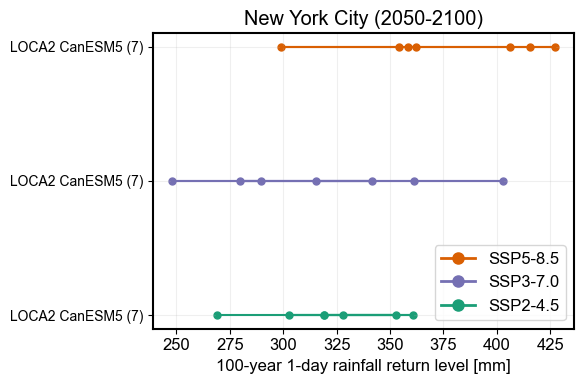

In [19]:
# Select example
plt.rcParams.update({'font.size': 12})

gcm = "CanESM5"
ensemble = "LOCA2"

df_sel = df[(df["gcm"] == gcm) & (df["ensemble"] == ensemble)]

fig, ax = plt.subplots(figsize=(6,4))

pu.plot_boxplot_all(df=df_sel,
                    plot_col = "100yr_return_level",
                    xlabel = "100-year 1-day rainfall return level [mm]",
                    title = "New York City (2050-2100)",
                    ax=ax)
plt.tight_layout()
plt.savefig('../figs/nyc_max_pr_example.pdf')

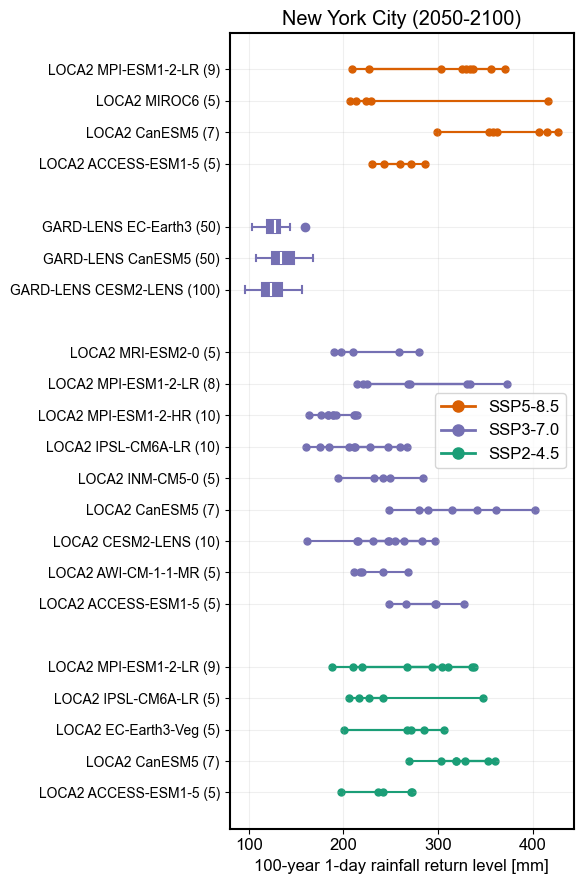

In [20]:
# All
plt.rcParams.update({'font.size': 12})

df_sel = df[(df["ssp"] != "historical") & (df["ensemble"] != "STAR-ESDM")]

fig, ax = plt.subplots(figsize=(6,9))

pu.plot_boxplot_all(df=df_sel,
                    plot_col = "100yr_return_level",
                    xlabel = "100-year 1-day rainfall return level [mm]",
                    title = "New York City (2050-2100)",
                    ax=ax)
plt.tight_layout()
plt.savefig('../figs/nyc_max_pr_example_all.pdf')

### Breakdown by uncertainty source

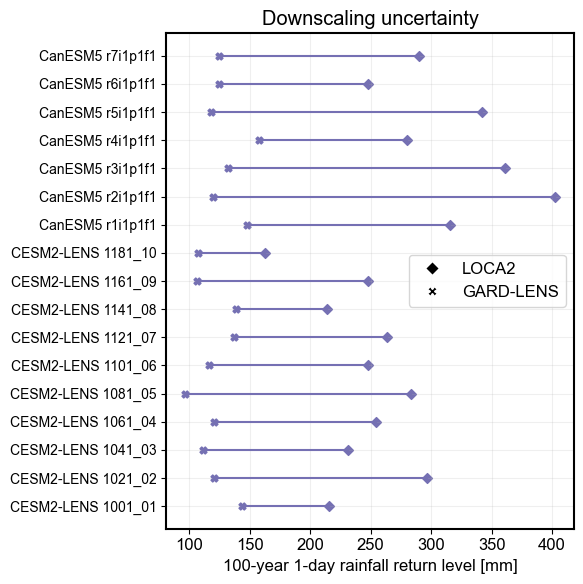

In [3]:
# Read
metric_id = "max_pr"
grid = "original"
proj_slice = "2050-2100"
hist_slice = "1950-2014"
stationary = True
stat_str = "stat" if stationary else "nonstat"
fit_method = "lmom"
cols_to_keep = ["20yr_return_level", "50yr_return_level", "100yr_return_level", "200yr_return_level"]
col_identifier = "return_levels"

city = "nyc"

df = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}.csv")
df_sel = df[df["ssp"] == "ssp370"]

# Plot
fig, ax = plt.subplots(figsize=(6,6))

pu.plot_ds_differences(df = df_sel,
                       plot_col = "100yr_return_level",
                       xlabel = "100-year 1-day rainfall return level [mm]",
                       ssp_legend=False, ax=ax)

plt.tight_layout()
plt.savefig('../figs/nyc_example_ds_uncertainty.pdf')

### Validation

In [4]:
# Read
metric_id = "max_pr"
proj_slice = "2050-2100"
hist_slice = "1950-2014"
stationary = True
stat_str = "stat" if stationary else "nonstat"
fit_method = "lmom"
cols_to_keep = ["20yr_return_level", "50yr_return_level", "100yr_return_level", "200yr_return_level"]
col_identifier = "return_levels"

city = "nyc"

# df_locagrid = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}_nearest.csv")
# df_locagrid_sel = df_locagrid[df_locagrid['ssp'] != 'historical']

df = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}.csv")
df_sel = df[df['ssp'] != 'historical']

In [6]:
sacu.calculate_df_uc(df_sel, "100yr_return_level")

ssp_uc  ssp_uc_by_gcm     gcm_uc     iv_uc      ds_uc
0  32.364954      41.588607  83.356852  105.4879  129.22165

In [8]:
import xarray as xr

In [10]:
plot_col = "100yr_return_level"

In [11]:
# Check against map
ds_uc = xr.open_dataset(f'{project_data_path}/results/{metric_id}_{proj_slice}_None_{plot_col}_{fit_method}_{stat_str}_LOCA2grid_nearest.nc')

In [12]:
ds_uc.sel(lat=city_list[city][0], lon=360+city_list[city][1], method='nearest').load()

<xarray.Dataset> Size: 72B
Dimensions:        ()
Coordinates:
    lon            float32 4B 286.0
    lat            float32 4B 40.72
Data variables:
    ssp_uc_by_gcm  float64 8B 41.59
    ssp_uc         float64 8B 32.36
    gcm_uc         float64 8B 83.36
    iv_uc          float64 8B 105.5
    dsc_uc         float64 8B 129.2
    uc_range       float64 8B 349.0
    uc_99w         float64 8B 337.3
    uc_95w         float64 8B 288.0

### Comparing GEV fits

In [201]:
metric_id = "max_pr"
grid = "original"
city = "nyc"

### Non-stat
proj_slice = "2015-2100"
stationary = False
stat_str = "stat" if stationary else "nonstat"
fit_method = "mle"
cols_to_keep = ["loc_intcp", "loc_trend", "scale", "shape"]

df_nonstat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stat_str}.csv")

# Add in 100-year RL in 2100
return_period = 100
return_period_year = 2075

if metric_id == "min_tasmin":
    scalar = -1.0
else:
    scalar = 1.0

df_nonstat[f'{return_period}yr_rl_{return_period_year}'] = scalar *  gevu.estimate_return_level(return_period, 
                                                                                      df_nonstat['loc_intcp'] + (df_nonstat['loc_trend'] * (return_period_year - 2015)),
                                                                                      df_nonstat['scale'],
                                                                                      df_nonstat['shape'])
    

df_nonstat_sel = df_nonstat[(df_nonstat["ssp"] != "historical") & (df_nonstat["gcm"] != "TaiESM1")]
df_nonstat_uc = sacu.calculate_df_uc(df_nonstat_sel, f'{return_period}yr_rl_{return_period_year}', False)

### Stat
proj_slice = "2050-2100"
hist_slice = "1950-2014"
stationary = True
stat_str = "stat" if stationary else "nonstat"
fit_method = "lmom"
cols_to_keep = ["100yr_return_level"]
col_identifier = "return_levels"

df_stat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}.csv")
df_stat_sel = df_stat[(df_stat["ssp"] != "historical") & (df_stat["gcm"] != "TaiESM1")]
df_stat_uc = sacu.calculate_df_uc(df_stat_sel, "100yr_return_level", False)

#### Bayes
store_path = f"{project_data_path}/extreme_value/cities/original_grid/bayes_combined/"

stationary = False
stationary_string = "stat" if stationary else "nonstat"

prior_identifier = "shape_sigma_02"
year = 2075
change_identifier = "" 

df_bayes = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")

# Drop bad
df_bayes_sel = df_bayes[(df_bayes["ssp"] != "historical") & df_bayes["rhat_good"]]
df_bayes_sel = df_bayes_sel[(df_bayes_sel["gcm"] != "TaiESM1")]

# Select year
if year is not None:
    df_bayes_sel = df_bayes_sel[df_bayes_sel["time"] == year]

# UC
df_bayes_uc = sacu.calculate_df_uc(df_bayes_sel, "100yr_return_level", True)

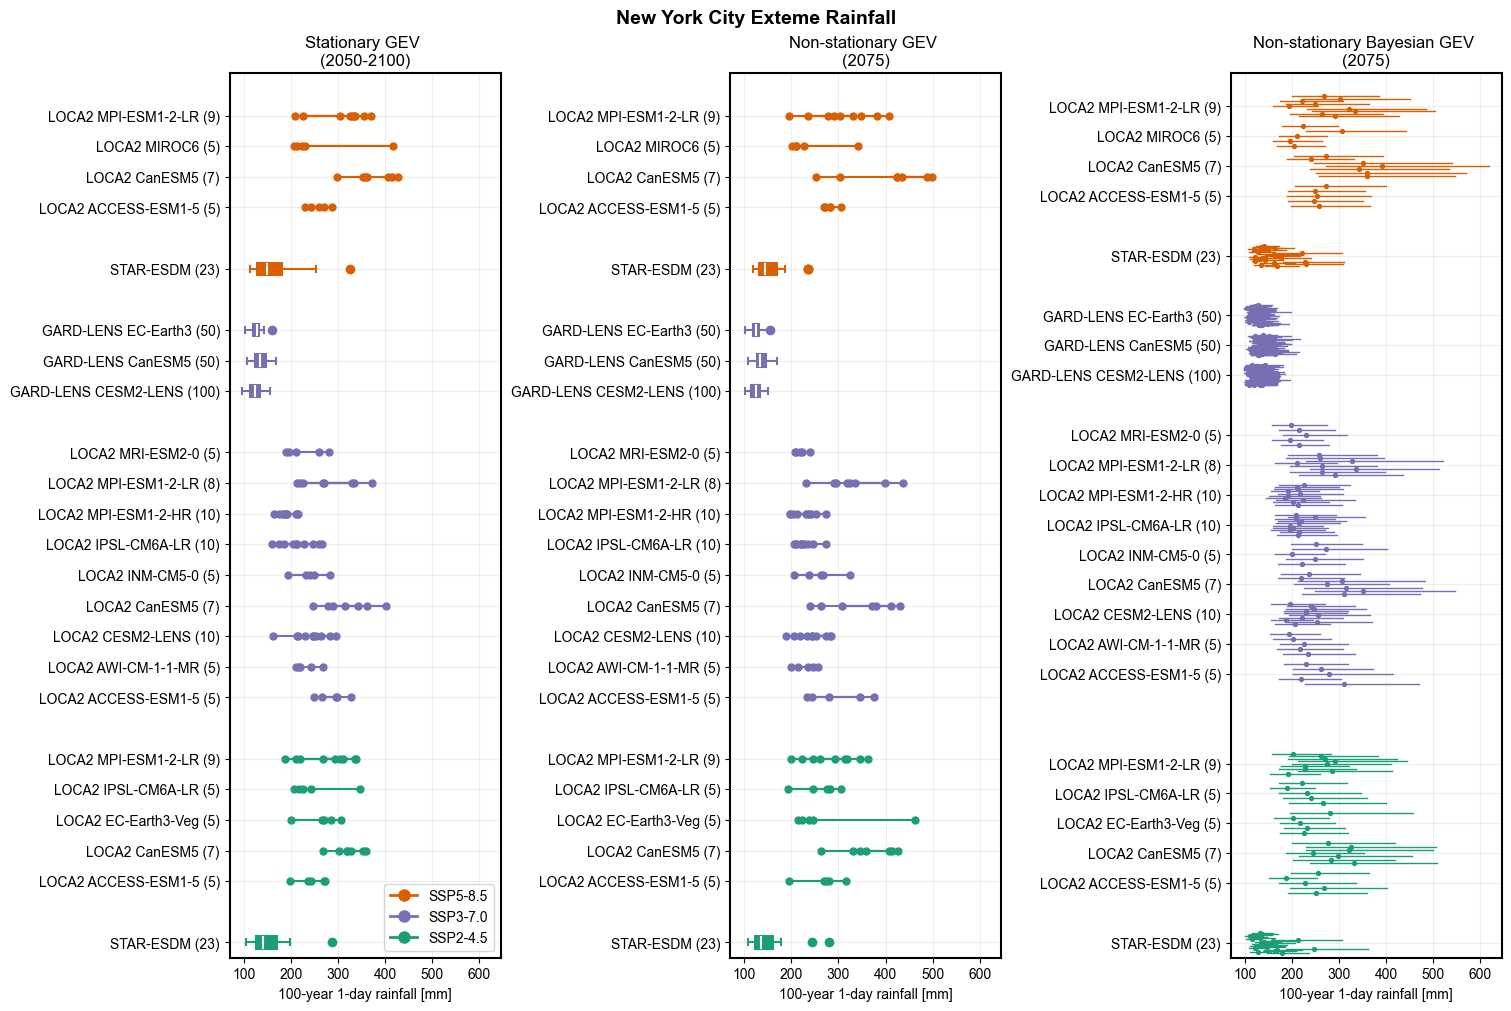

In [202]:
# Return level plots
# xlabel = "100-year maximum temperature [C]"
# xlabel = "100-year minimum temperature [C]"
xlabel = "100-year 1-day rainfall [mm]"

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1, 3, figsize=(15,10), sharey=False, sharex=True, layout='constrained')

pu.plot_boxplot_all(df = df_stat_sel,
                    plot_col = "100yr_return_level",
                    xlabel = xlabel,
                    title = "Stationary GEV \n(2050-2100)",
                    ax=axs[0])

pu.plot_boxplot_all(df = df_nonstat_sel,
                    plot_col = f'{return_period}yr_rl_{return_period_year}',
                    xlabel = xlabel,
                    title = "Non-stationary GEV \n(2075)",
                    legend=False,
                    ax=axs[1])

pu.plot_boxplot_all_bayes(df = df_bayes_sel, 
                          plot_col = '100yr_return_level',
                          xlabel = xlabel,
                          title = 'Non-stationary Bayesian GEV \n(2075)',
                          lw = 1,
                          s = 8,
                          legend=False,
                          idx_step = 1,
                          ax=axs[2])

axs[2].set_ylim([0.5, axs[2].get_ylim()[1]-2/3])

fig.suptitle("New York City Exteme Rainfall", fontweight='bold', fontsize=14)
plt.savefig(f'../figs/{city}_{metric_id}_rl_all_fits.pdf')

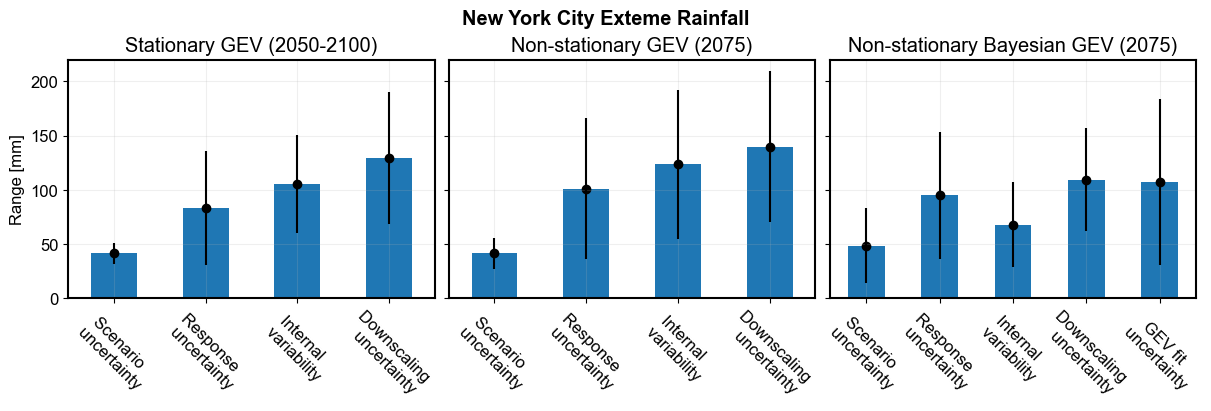

In [203]:
# UC plots
units = "mm"
# units = "C"

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True, layout='constrained')

uc_types = ['ssp_uc_by_gcm', 'gcm_uc', 'iv_uc', 'ds_uc', 'gev_uc']

uc_names = ['Scenario \n uncertainty',
            'Response \n uncertainty', 
            'Internal \n variability',
            'Downscaling \n uncertainty',
            'GEV fit \n uncertainty']

# Stat
ax=axs[0]
df_plot = df_stat_uc.set_index('uncertainty_type').loc[uc_types[:-1]]
df_plot.plot.bar(y='mean', yerr='std', ax=ax, xlabel='', ylabel=f'Range [{units}]')
ax.scatter(np.arange(len(uc_types[:-1])), df_plot['mean'], color='black')
ax.set_title('Stationary GEV (2050-2100)')
ax.set_xticklabels(uc_names[:-1], rotation=-45)

# Non-stat
ax=axs[1]
df_plot = df_nonstat_uc.set_index('uncertainty_type').loc[uc_types[:-1]]
df_plot.plot.bar(y='mean', yerr='std', ax=ax, xlabel='', ylabel=f'Range [{units}]')
ax.scatter(np.arange(len(uc_types[:-1])), df_plot['mean'], color='black')
ax.set_title('Non-stationary GEV (2075)')
ax.set_xticklabels(uc_names[:-1], rotation=-45)

# Bayes
ax=axs[2]
df_plot = df_bayes_uc.set_index('uncertainty_type').loc[uc_types]
df_plot.plot.bar(y='mean', yerr='std', ax=ax, xlabel='', ylabel=f'Range [{units}]')
ax.scatter(np.arange(len(uc_types)), df_plot['mean'], color='black')
ax.set_title('Non-stationary Bayesian GEV (2075)')
ax.set_xticklabels(uc_names, rotation=-45)

# Tidy
for ax in axs:
    ax.get_legend().remove()
    ax.grid(alpha=0.2, zorder=3)

fig.suptitle("New York City Exteme Rainfall", fontweight='bold')
plt.savefig(f'../figs/{city}_{metric_id}_uc_all_fits.pdf')

### Changes

In [204]:
def get_differences(df_all, plot_col):
    # Plot differences
    df_plot = pd.merge(df_all[df_all["ssp"] == "historical"].set_index(["ensemble", "gcm", "member"])[[plot_col]],
                       df_all[df_all["ssp"] != "historical"].set_index(["ensemble", "gcm", "member"])[[plot_col, "ssp"]],
                       on=["ensemble", "gcm", "member"],
                       suffixes=("_hist", "_proj"),
                      ).reset_index()

    df_plot[plot_col] = df_plot[f"{plot_col}_proj"] - df_plot[f"{plot_col}_hist"]

    return df_plot

In [219]:
metric_id = "min_tasmin"
grid = "original"
city = "nyc"

### Non-stat
proj_slice = "2015-2100"
stationary = False
stat_str = "stat" if stationary else "nonstat"
fit_method = "mle"
cols_to_keep = ["loc_intcp", "loc_trend", "scale", "shape"]

df_nonstat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stat_str}.csv")

# Add in 100-year RL in 2100
return_period = 100
return_period_year = 2075

if metric_id == "min_tasmin":
    scalar = -1.0
else:
    scalar = 0.0

df_nonstat[f'{return_period}yr_rl_{return_period_year}'] = scalar *  gevu.estimate_return_level(return_period, 
                                                                                      df_nonstat['loc_intcp'] + (df_nonstat['loc_trend'] * (return_period_year - 2015)),
                                                                                      df_nonstat['scale'],
                                                                                      df_nonstat['shape'])
    

df_nonstat_sel = df_nonstat[(df_nonstat["ssp"] != "historical") & (df_nonstat["gcm"] != "TaiESM1")]
df_nonstat_uc = sacu.calculate_df_uc(df_nonstat_sel, f'{return_period}yr_rl_{return_period_year}', False)

### Stat
proj_slice = "2050-2100"
hist_slice = "1950-2014"
stationary = True
stat_str = "stat" if stationary else "nonstat"
fit_method = "lmom"
plot_col = "100yr_return_level"
col_identifier = "return_levels"

df_stat = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{hist_slice}_{col_identifier}_{fit_method}_{stat_str}.csv")
df_stat_sel = df_stat[(df_stat["gcm"] != "TaiESM1")]

# Differences
df_stat_sel_changes = get_differences(df_stat_sel, plot_col)

 # UC
df_stat_changes_uc = sacu.calculate_df_uc(df_stat_sel_changes, plot_col, False)

df_stat_sel = df_stat_sel[df_stat_sel['ssp'] != 'historical']
df_stat_uc = sacu.calculate_df_uc(df_stat_sel, plot_col, False)

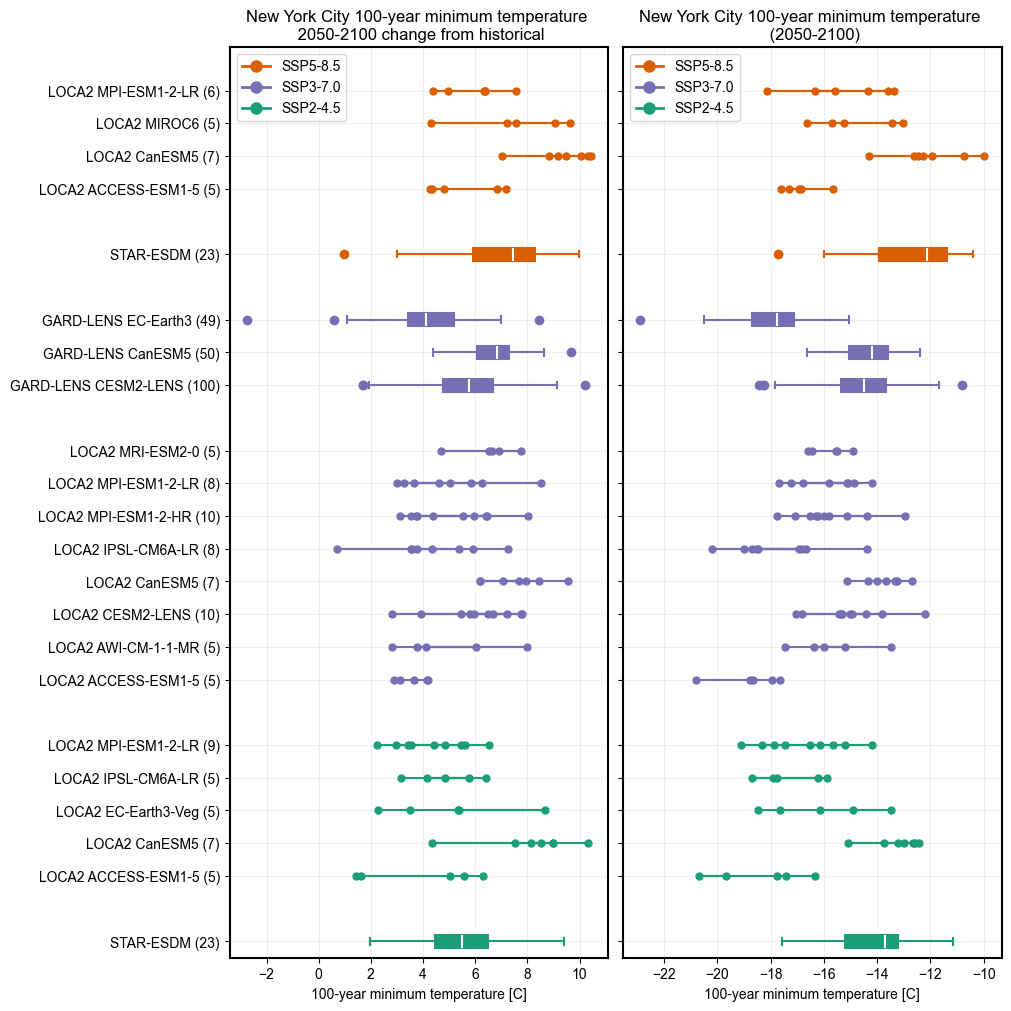

In [220]:
# Return level plots
plt.rcParams.update({'font.size': 12})

# xlabel = "100-year maximum temperature [C]"
xlabel = "100-year minimum temperature [C]"
# xlabel = "100-year 1-day rainfall [mm]"

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True, sharex=False, layout='constrained')

pu.plot_boxplot_all(df = df_stat_sel,
                    plot_col = plot_col,
                    xlabel = xlabel,
                    title = 'New York City 100-year minimum temperature \n (2050-2100)',
                    ax=axs[1])

pu.plot_boxplot_all(df = df_stat_sel_changes,
                    plot_col = plot_col,
                    xlabel = xlabel,
                    title = 'New York City 100-year minimum temperature \n 2050-2100 change from historical', 
                    ax=axs[0])

plt.savefig(f'../figs/{city}_{metric_id}_rl_all_fits.pdf')

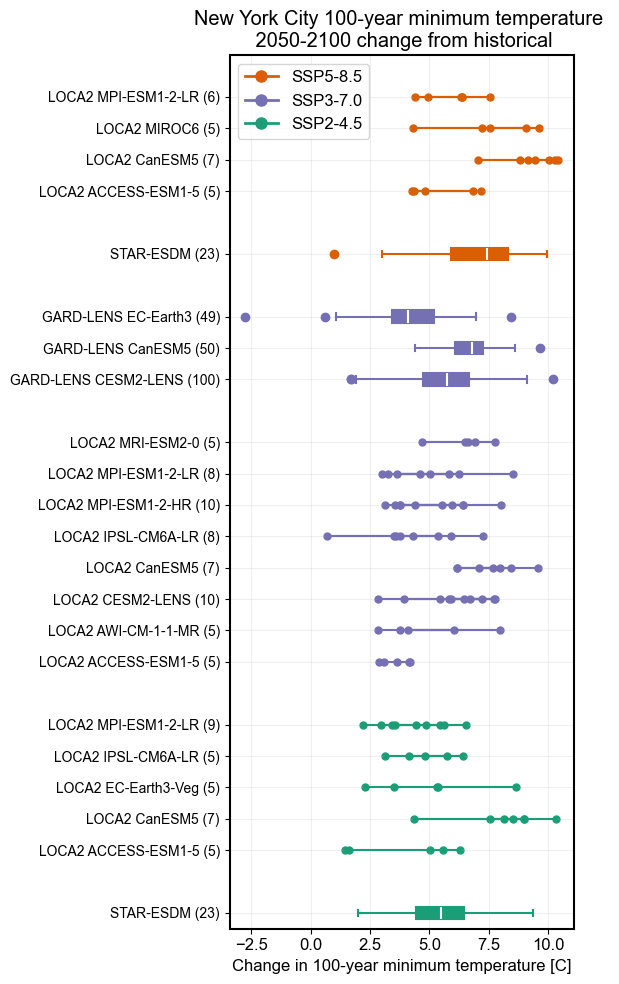

In [221]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(figsize=(6,10))

# xlabel = "Change in 100-year maximum temperature [C]"
xlabel = "Change in 100-year minimum temperature [C]"
# xlabel = "Change in 100-year 1-day rainfall [mm]"

pu.plot_boxplot_all(df = df_stat_sel_changes,
                    plot_col = plot_col,
                    xlabel = xlabel,
                    title = 'New York City 100-year minimum temperature \n 2050-2100 change from historical', 
                    ax=ax)

plt.tight_layout()
plt.savefig(f'../figs/{city}_{metric_id}_change_RLs.pdf')

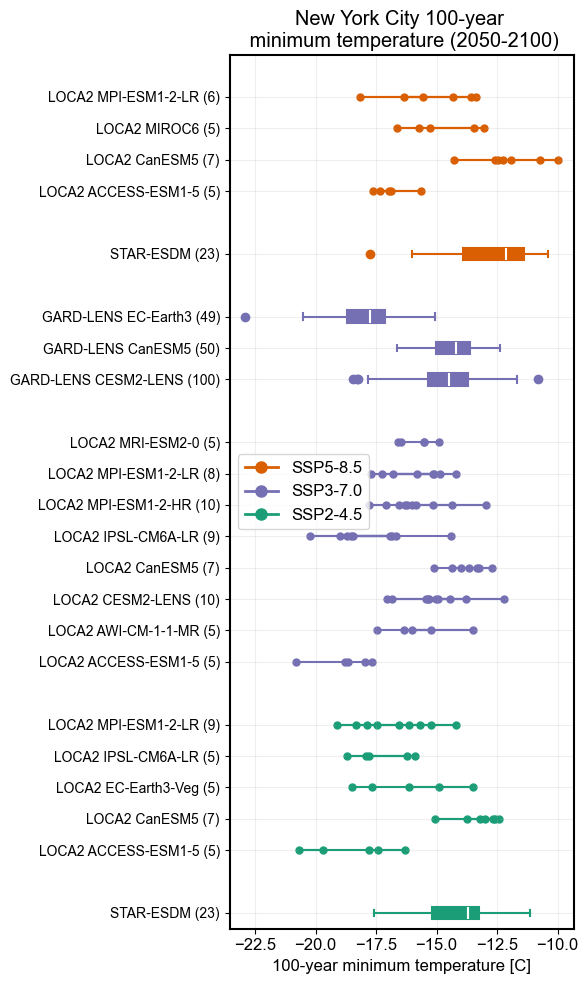

In [222]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(figsize=(6,10))

# xlabel = "100-year maximum temperature [C]"
xlabel = "100-year minimum temperature [C]"
# xlabel = "100-year 1-day rainfall [mm]"

pu.plot_boxplot_all(df = df_stat_sel,
                    plot_col = plot_col,
                    xlabel = xlabel,
                    title = 'New York City 100-year \n minimum temperature (2050-2100)',
                    ax=ax)

plt.tight_layout()
plt.savefig(f'../figs/{city}_{metric_id}_RLs.pdf')

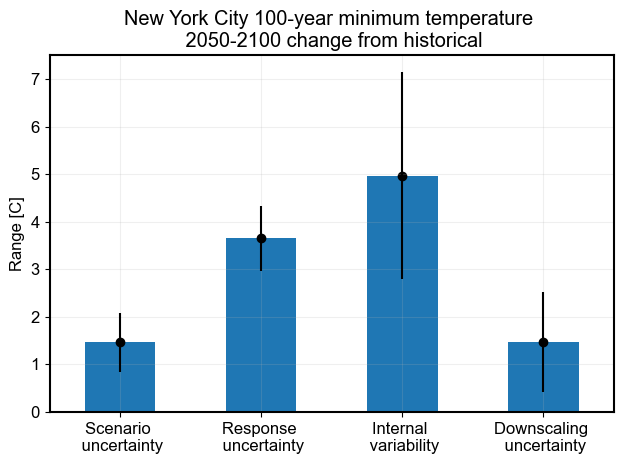

In [223]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots()

# units = "mm"
units = "C"

uc_types = ['ssp_uc_by_gcm', 'gcm_uc', 'iv_uc', 'ds_uc', 'gev_uc']

uc_names = ['Scenario \n uncertainty',
            'Response \n uncertainty', 
            'Internal \n variability',
            'Downscaling \n uncertainty',
            'GEV fit \n uncertainty']

# Stat
df_plot = df_stat_changes_uc.set_index('uncertainty_type').loc[uc_types[:-1]]
df_plot.plot.bar(y='mean', yerr='std', ax=ax, xlabel='', ylabel=f'Range [{units}]')
ax.scatter(np.arange(len(uc_types[:-1])), df_plot['mean'], color='black')

ax.set_title('New York City 100-year minimum temperature \n 2050-2100 change from historical')
ax.set_xticklabels(uc_names[:-1], rotation=0)
ax.get_legend().remove()
ax.grid(alpha=0.2, zorder=3)

plt.tight_layout()
plt.savefig(f'../figs/{city}_{metric_id}_change_uc.pdf')

In [ ]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots()

# units = "mm"
units = "C"

uc_types = ['ssp_uc_by_gcm', 'gcm_uc', 'iv_uc', 'ds_uc', 'gev_uc']

uc_names = ['Scenario \n uncertainty',
            'Response \n uncertainty', 
            'Internal \n variability',
            'Downscaling \n uncertainty',
            'GEV fit \n uncertainty']

# Stat
df_plot = df_stat_uc.set_index('uncertainty_type').loc[uc_types[:-1]]
df_plot.plot.bar(y='mean', yerr='std', ax=ax, xlabel='', ylabel=f'Range [{units}]')
ax.scatter(np.arange(len(uc_types[:-1])), df_plot['mean'], color='black')
ax.set_title('New York City 100-year minimum temperature \n (2050-2100)')
ax.set_xticklabels(uc_names[:-1], rotation=0)
ax.get_legend().remove()
ax.grid(alpha=0.2, zorder=3)

plt.tight_layout()
plt.savefig(f'../figs/{city}_{metric_id}_uc.pdf')

### Cities

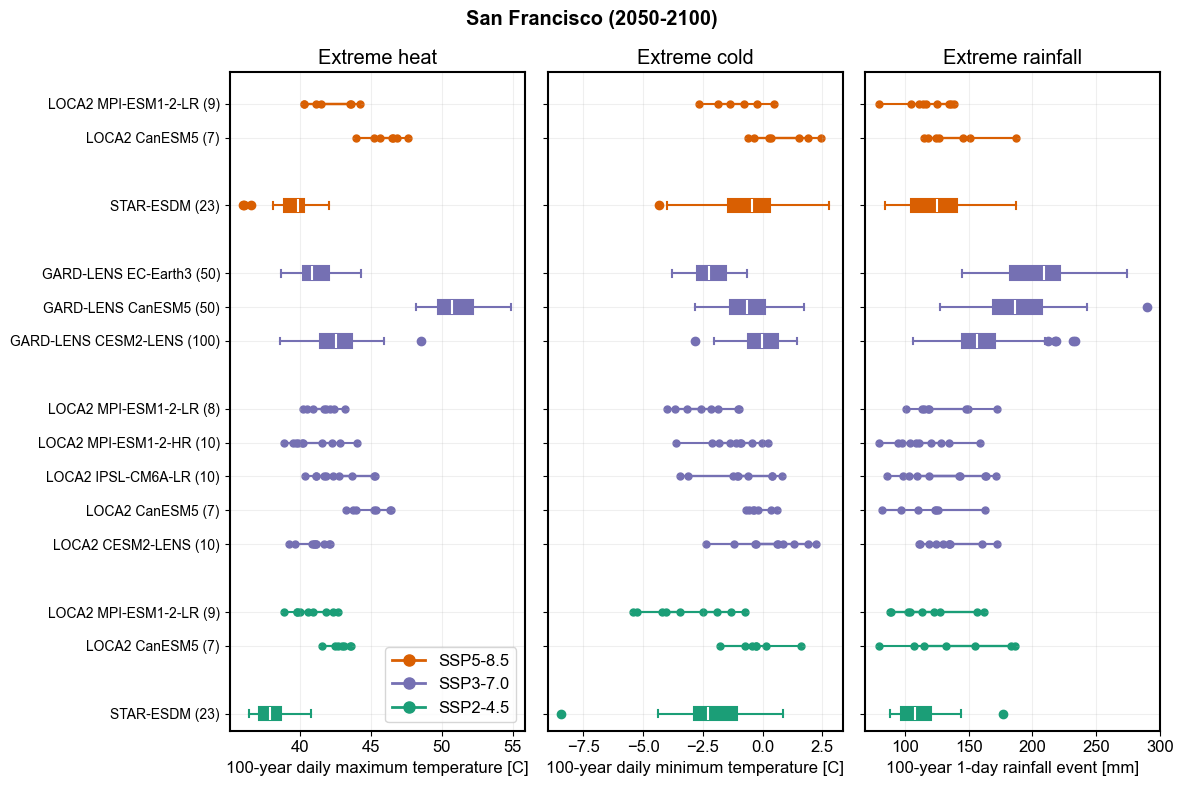

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,8), sharey=True)

city = 'sanfrancisco'
city_name = 'San Francisco'
plot_diff = False
plot_diff_str = "_change" if plot_diff else ""
title_diff_str = " change from historical" if plot_diff else ""

pu.plot_city(city, 'max_tasmax', 100, True, "lmom", axs[0], "100-year daily maximum temperature [C]", "Extreme heat", True, min_members=6, plot_diff=plot_diff)
pu.plot_city(city, 'min_tasmin', 100, True, "lmom", axs[1], "100-year daily minimum temperature [C]", "Extreme cold", False, min_members=6, plot_diff=plot_diff)
pu.plot_city(city, 'max_pr', 100, True, "lmom", axs[2], "100-year 1-day rainfall event [mm]", "Extreme rainfall", False, min_members=6, plot_diff=plot_diff)

fig.suptitle(f'{city_name} (2050-2100)', fontweight='bold')
plt.tight_layout()

plt.savefig(f'../figs/{city}_RLs{plot_diff_str}.pdf')

### Bayesian

In [19]:
## Bayesian
store_path = f"{project_data_path}/extreme_value/cities/original_grid/bayes_combined/"

stationary = False
stationary_string = "stat" if stationary else "nonstat"

prior_identifier = "shape_sigma_02"
year = 2075
change_identifier = "" 

# NYC pr
city = 'nyc'
metric_id = 'max_tasmax'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")

# Drop bad
df_sel = df[(df["ssp"] != "historical") & df["rhat_good"]]
df_sel = df_sel[(df_sel["gcm"] != "TaiESM1")]

# Select year
if year is not None:
    df_sel = df_sel[df_sel["time"] == year]

<Axes: ylabel='Frequency'>

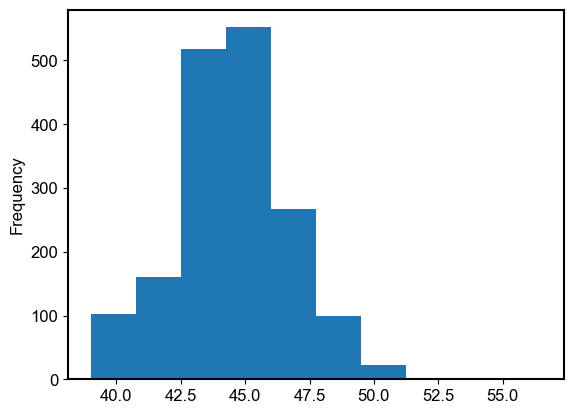

In [21]:
df_sel['100yr_return_level'].plot.hist()

<Axes: xlabel='uncertainty_type'>

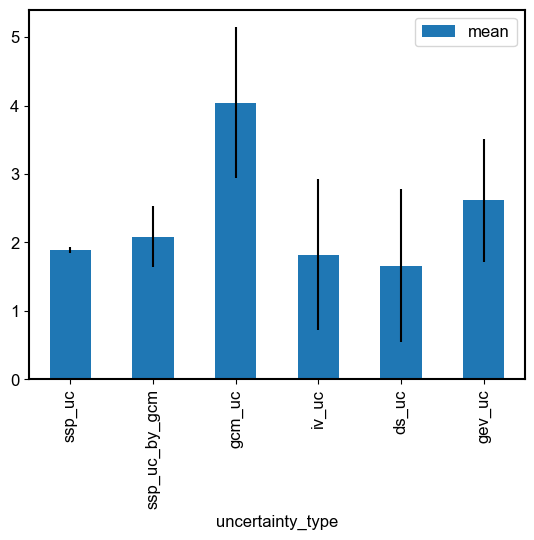

In [23]:
sacu.calculate_df_uc(df_sel, "100yr_return_level", True).plot.bar(x='uncertainty_type', y='mean', yerr='std')

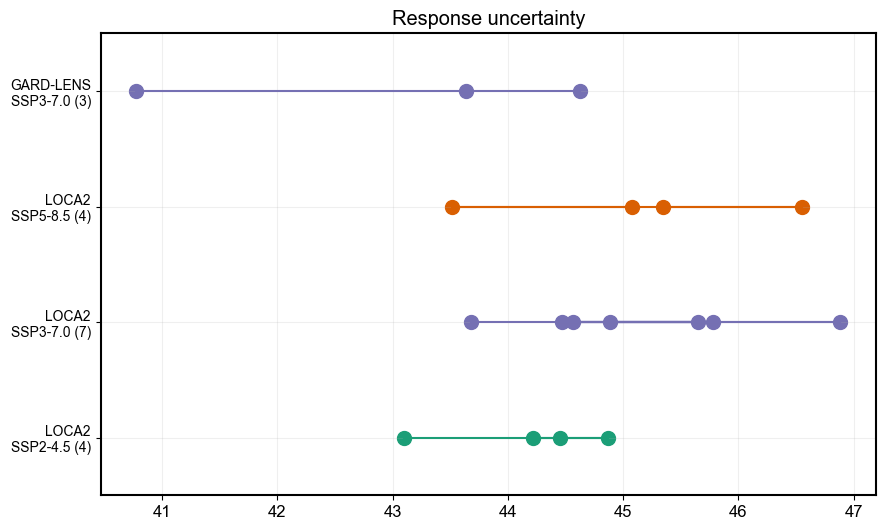

In [42]:
pu.plot_response_differences(df_sel[df_sel['quantile'] == '0.5'], "100yr_return_level", '')

### Other

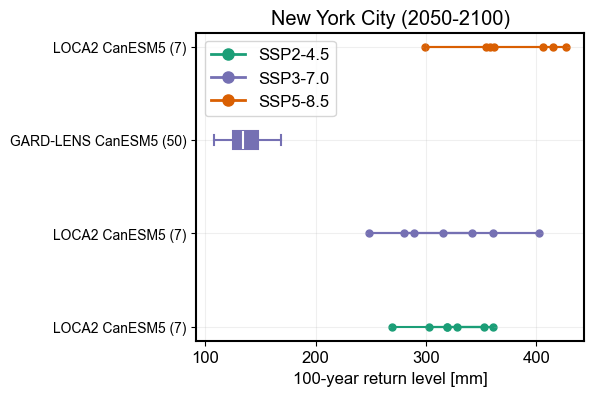

In [21]:
# Select example
gcm = "CanESM5"
ensemble = "LOCA2"

df_sel = df[(df["gcm"] == gcm)]

fig, ax = plt.subplots(figsize=(5,4))

pu.plot_boxplot_all(df=df_sel,
                    plot_col = "100yr_return_level",
                    xlabel = "100-year return level [mm]",
                    title = "New York City (2050-2100)",
                    ax=ax
                   )
plt.show()

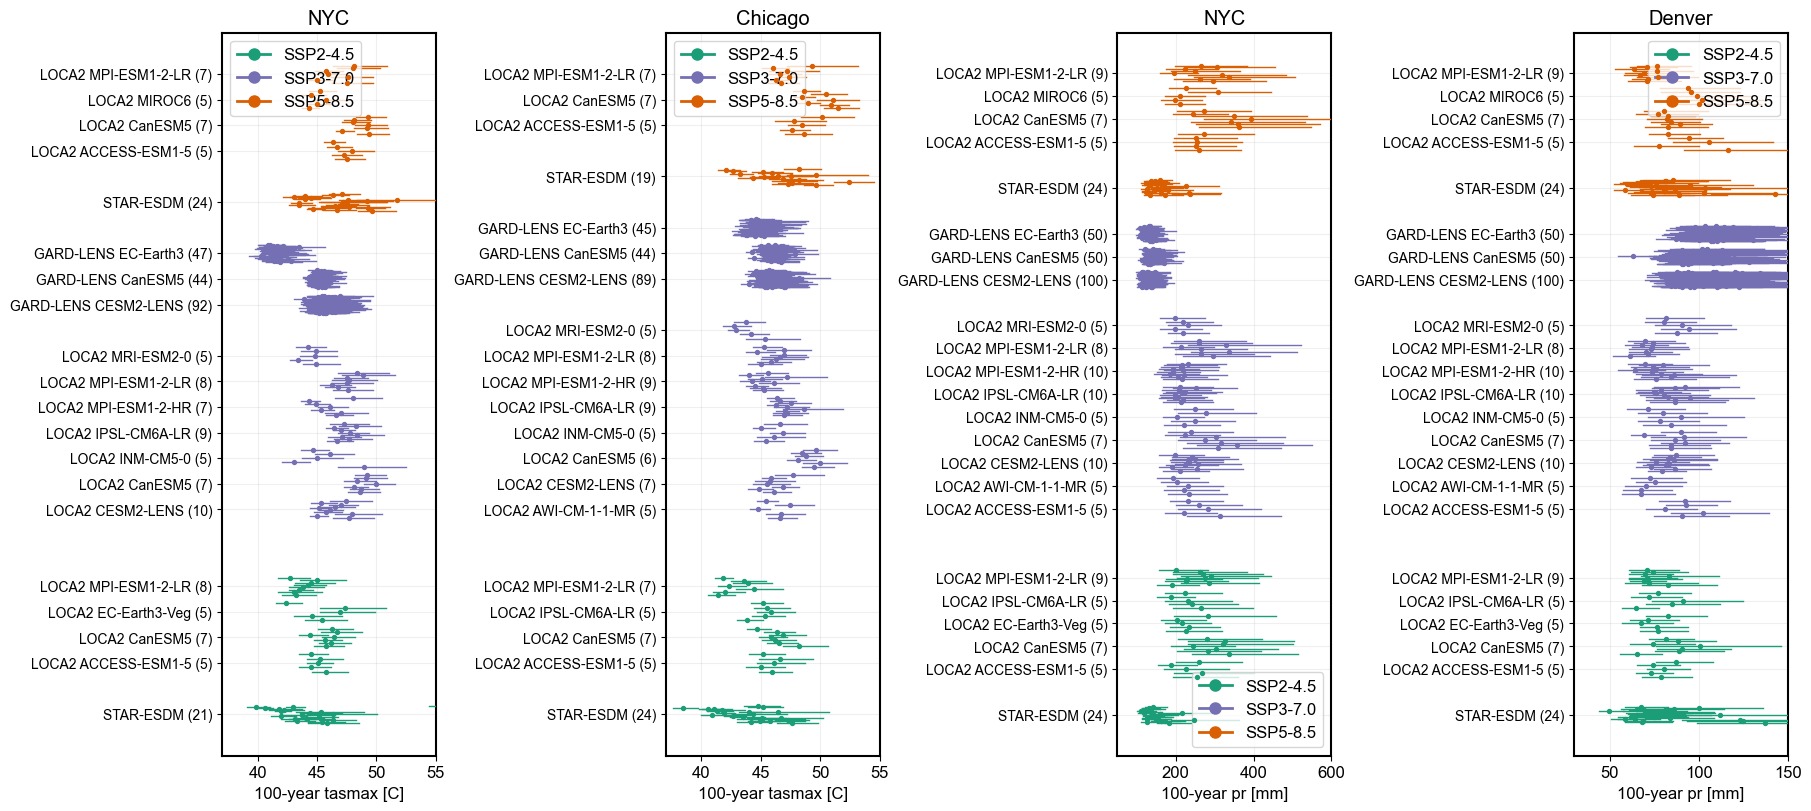

In [7]:
## Bayesian
store_path = f"{project_data_path}/extreme_value/cities/original_grid/bayes_combined/"

stationary = False
stationary_string = "stat" if stationary else "nonstat"

prior_identifier = "shape_sigma_02"
year = 2100
change_identifier = "" #"_change_2015-2100"

fig, axs = plt.subplots(1,4, figsize=(18,8), sharey=False, layout='constrained')

# NYC heat
city = 'nyc'
metric_id = 'max_tasmax'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]

pu.plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year tasmax [C]',
                       title = 'NYC',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[0]
                      )
axs[0].set_xlim([37,55])

# Chicago heat
city = 'chicago'
metric_id = 'max_tasmax'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
pu.plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year tasmax [C]',
                       title = 'Chicago',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[1]
                      )
axs[1].set_xlim([37,55])

# NYC pr
city = 'nyc'
metric_id = 'max_pr'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
pu.plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year pr [mm]',
                       title = 'NYC',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[2]
                      )

axs[2].set_xlim([50,600])

# Denver pr
city = 'denver'
metric_id = 'max_pr'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
pu.plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year pr [mm]',
                       title = 'Denver',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[3]
                      )

axs[3].set_xlim([30,200])

plt.show()

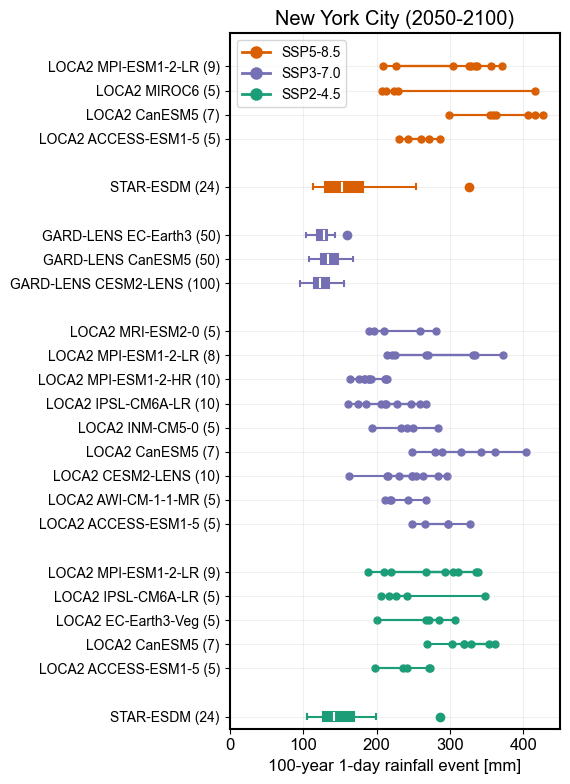

In [26]:
fig, ax = plt.subplots(figsize=(6,8))

pu.plot_city('nyc', 'max_pr', 100, ax, "100-year 1-day rainfall event [mm]", "New York City (2050-2100)", True, min_members=5, limits=[0,400])

legend_elements = [
            Line2D(
                [0],
                [0],
                color=ssp_colors[ssp],
                marker="o",
                markerfacecolor=ssp_colors[ssp],
                markersize=8,
                lw=2,
                label=ssp_labels[ssp],
            )
            for ssp in list(ssp_colors.keys())[::-1]
        ]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
ax.set_xlim([0,450])
plt.tight_layout()

plt.savefig('../figs/nyc_pr_rl100.png', dpi=300)

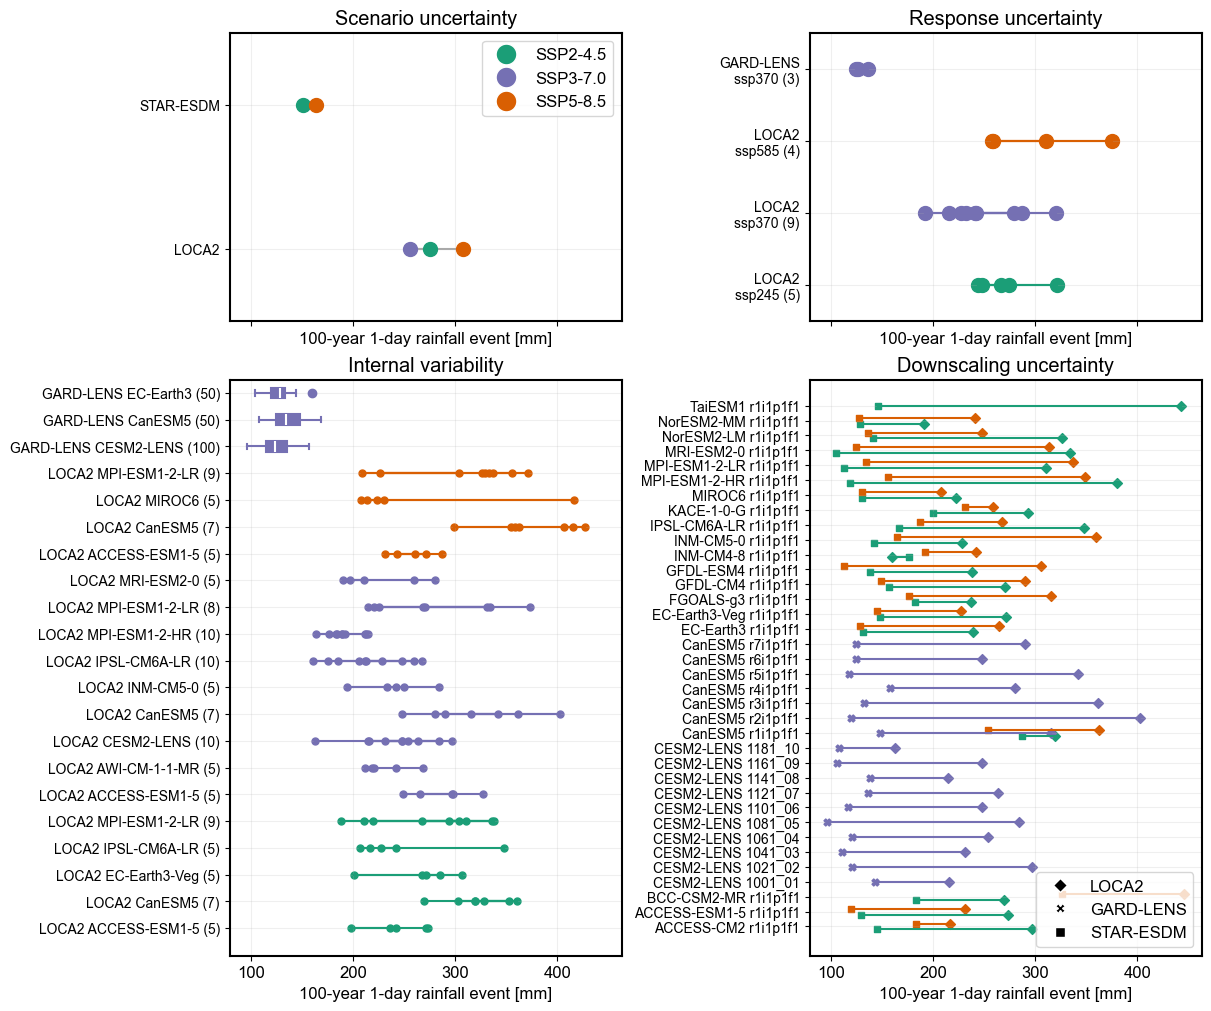

In [37]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day rainfall event [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)

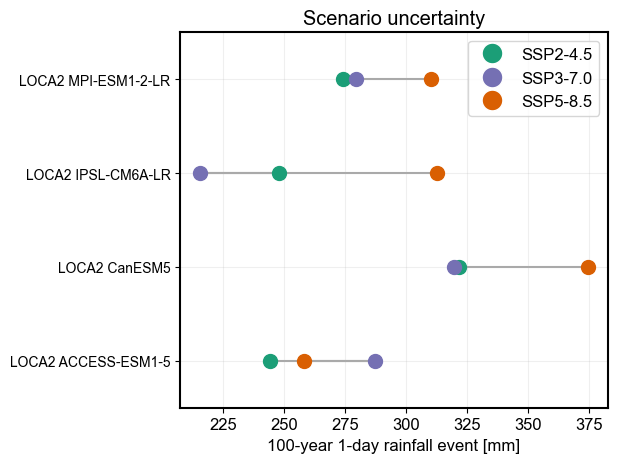

In [19]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day rainfall event [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

fig, ax = plt.subplots()

pu.plot_scenario_differences_by_gcm(df_all[df_all['ssp'] != 'historical'], plot_col, xlabel, ax=ax)
plt.tight_layout()
plt.savefig('../figs/nyc_example_scenario_uncertainty.png', dpi=300)

# pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
#                  plot_col = plot_col,
#                  xlabel = xlabel)

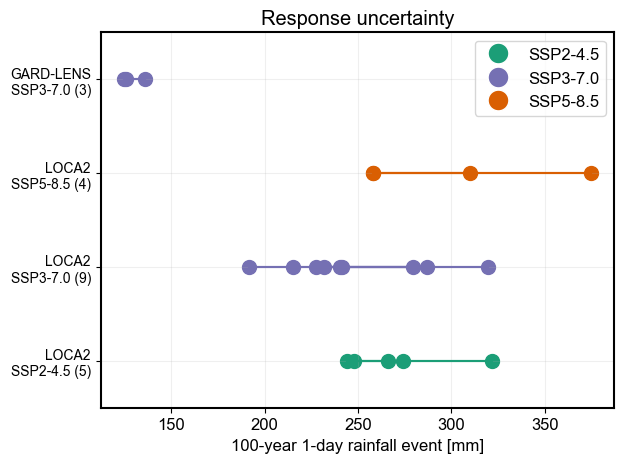

In [18]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day rainfall event [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

fig, ax = plt.subplots()

pu.plot_response_differences(df_all[df_all['ssp'] != 'historical'], plot_col, xlabel, ax=ax, legend=True)
plt.tight_layout()
plt.savefig('../figs/nyc_example_response_uncertainty.png', dpi=300)

# pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
#                  plot_col = plot_col,
#                  xlabel = xlabel)

In [12]:
np.mean([20,120, 120, 80])

85.0

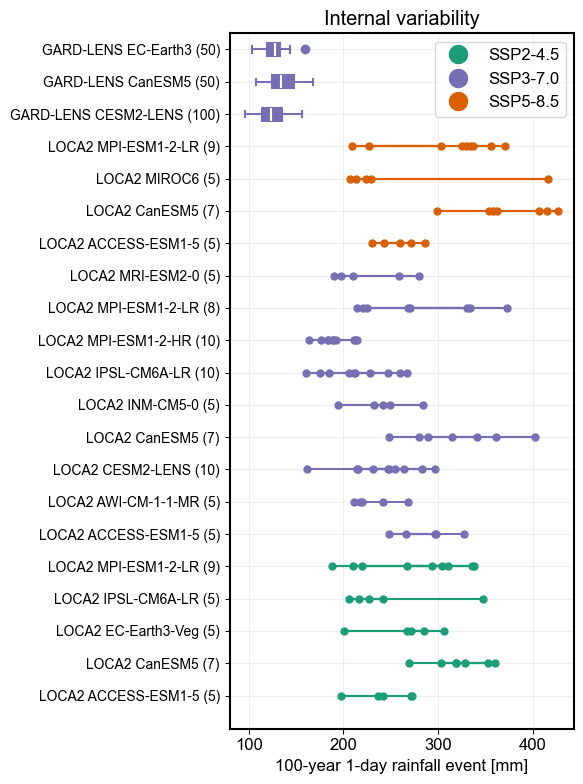

In [6]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day rainfall event [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

fig, ax = plt.subplots(figsize=(6,8))

pu.plot_iv_differences(df_all[df_all['ssp'] != 'historical'], plot_col, xlabel, ax=ax, legend=True)

plt.tight_layout()
plt.savefig('../figs/nyc_example_iv_uncertainty.png', dpi=300)

# pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
#                  plot_col = plot_col,
#                  xlabel = xlabel)

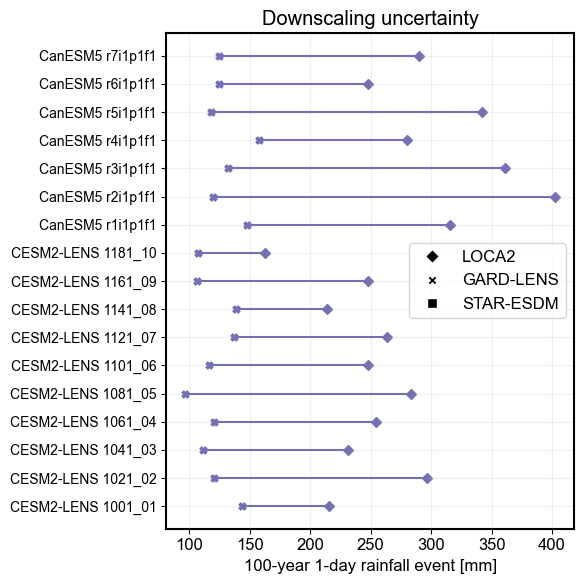

In [11]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day rainfall event [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

fig, ax = plt.subplots(figsize=(6,6))

pu.plot_ds_differences(df_all[df_all['ssp'] == 'ssp370'], plot_col, xlabel, ax=ax, ssp_legend=False)

plt.tight_layout()
plt.savefig('../figs/nyc_example_ds_uncertainty.png', dpi=300)

# pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
#                  plot_col = plot_col,
#                  xlabel = xlabel)

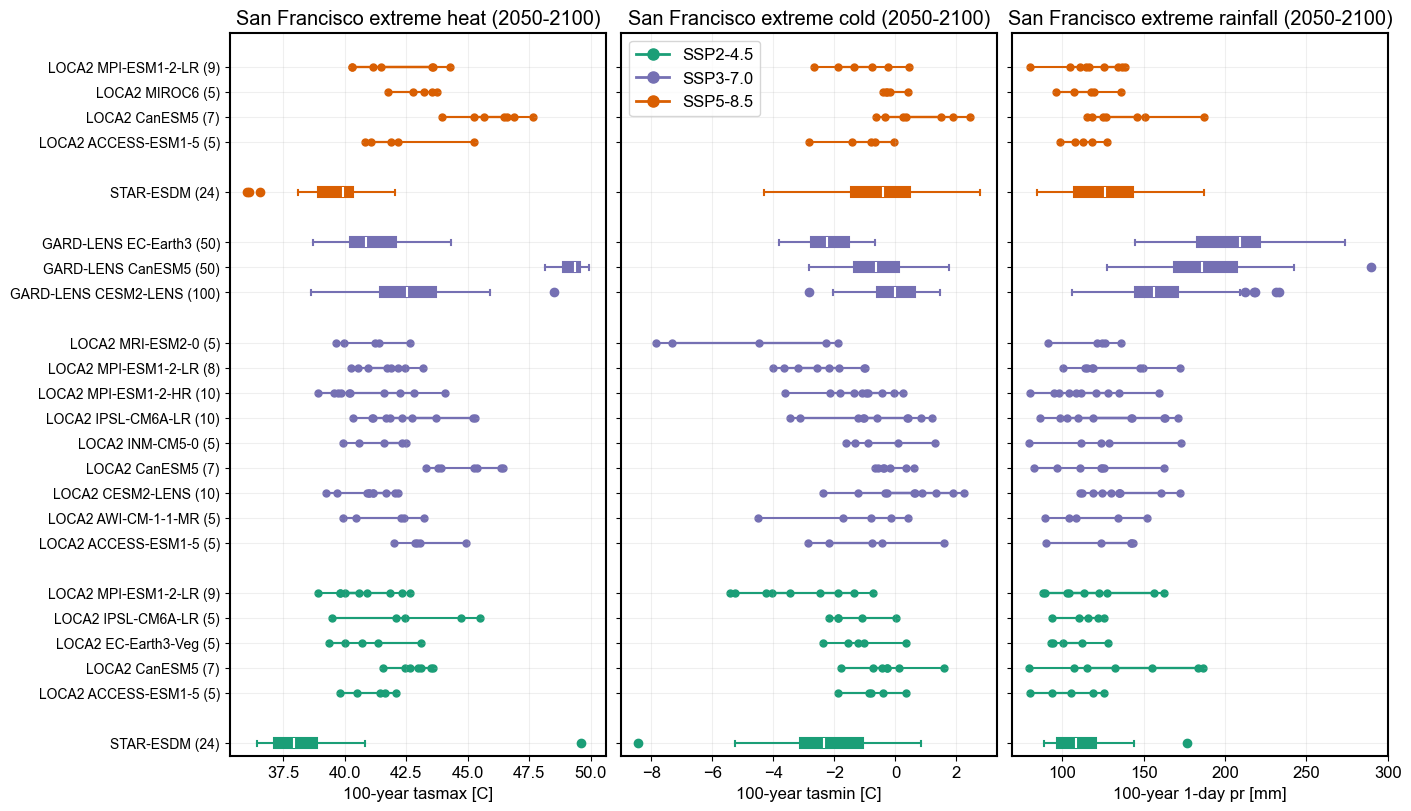

In [7]:
fig, axs = plt.subplots(1,3, figsize=(14,8), sharey=True, layout='constrained')

pu.plot_city('sanfrancisco', 'max_tasmax', 100, axs[0], "100-year tasmax [C]", "San Francisco extreme heat (2050-2100)", False, min_members=5, limits=[0,50])
pu.plot_city('sanfrancisco', 'min_tasmin', 100, axs[1], "100-year tasmin [C]", "San Francisco extreme cold (2050-2100)", True, min_members=5)
pu.plot_city('sanfrancisco', 'max_pr', 100, axs[2], "100-year 1-day pr [mm]", "San Francisco extreme rainfall (2050-2100)", False, min_members=5)

plt.savefig('../figs/sanfrancisco_example_all.pdf')

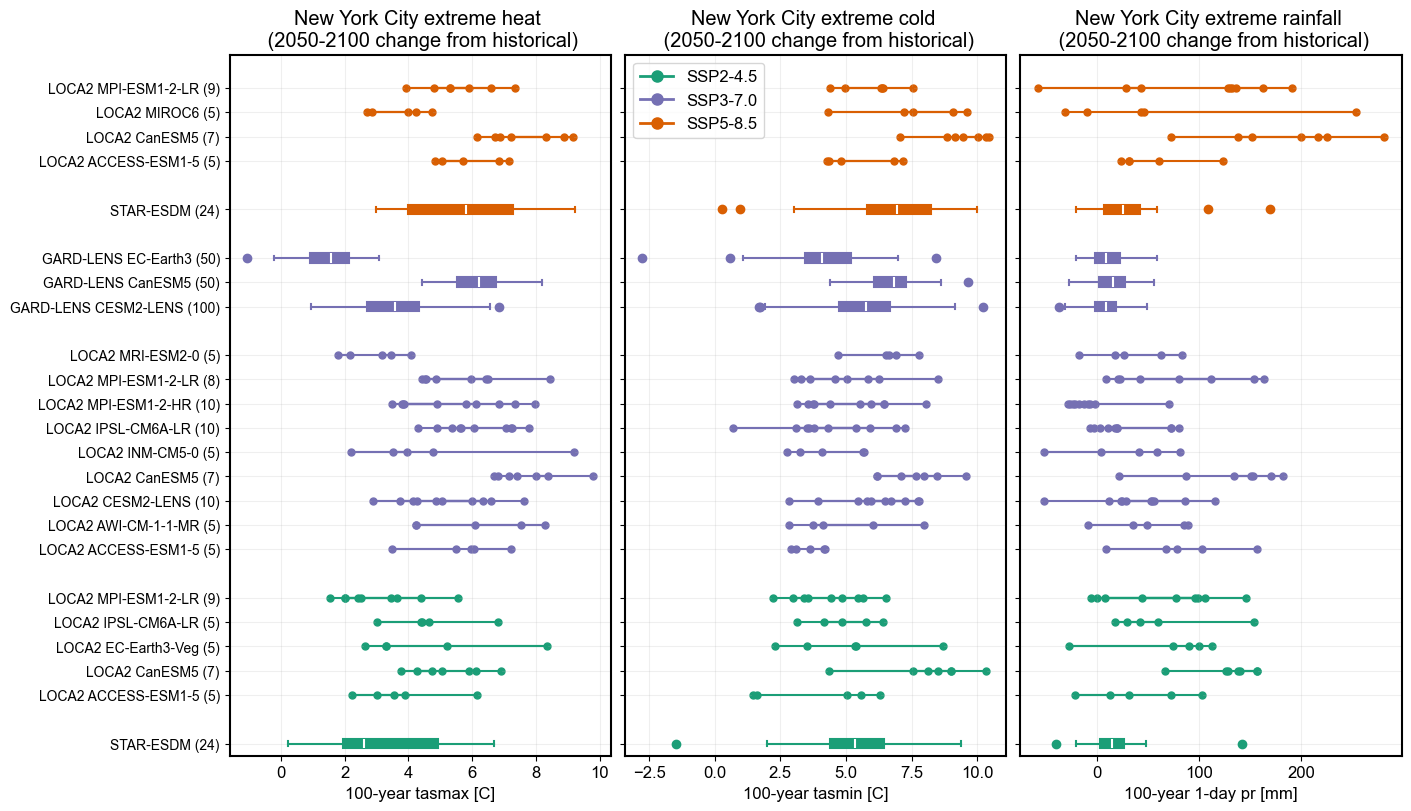

In [5]:
fig, axs = plt.subplots(1,3, figsize=(14,8), sharey=True, layout='constrained')

pu.plot_city('nyc', 'max_tasmax', 100, axs[0], "100-year tasmax [C]", "New York City extreme heat \n (2050-2100 change from historical)", False, min_members=5, limits=[-15,15], plot_diff=True)
pu.plot_city('nyc', 'min_tasmin', 100, axs[1], "100-year tasmin [C]", "New York City extreme cold \n (2050-2100 change from historical)", True, min_members=5, plot_diff=True)
pu.plot_city('nyc', 'max_pr', 100, axs[2], "100-year 1-day pr [mm]", "New York City extreme rainfall \n (2050-2100 change from historical)", False, min_members=5, plot_diff=True)

plt.savefig('../figs/nyc_example_all_change.pdf')

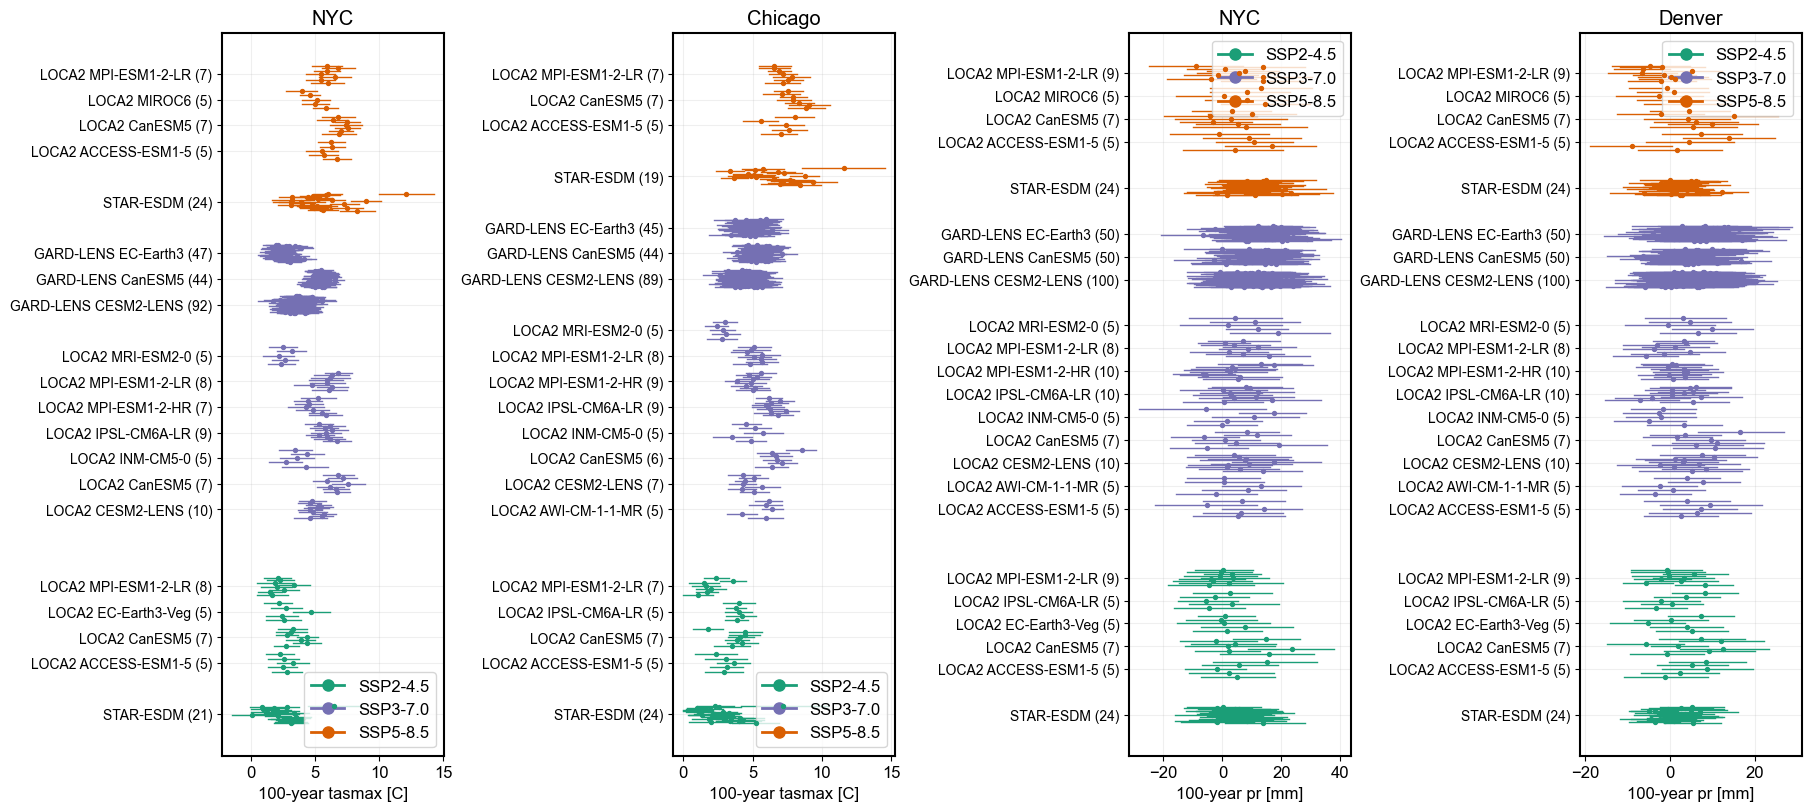

In [14]:
## Bayesian
store_path = f"{project_data_path}/extreme_value/cities/original_grid/bayes_combined/"

stationary = False
stationary_string = "stat" if stationary else "nonstat"

prior_identifier = "shape_sigma_02"
year = None
change_identifier = "_change_2015-2100"

fig, axs = plt.subplots(1,4, figsize=(18,8), sharey=False, layout='constrained')

# NYC heat
city = 'nyc'
metric_id = 'max_tasmax'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]

plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year tasmax [C]',
                       title = 'NYC',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[0]
                      )
# axs[0].set_xlim([37,55])

# Chicago heat
city = 'chicago'
metric_id = 'max_tasmax'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year tasmax [C]',
                       title = 'Chicago',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[1]
                      )
# axs[1].set_xlim([37,55])

# NYC pr
city = 'nyc'
metric_id = 'max_pr'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year pr [mm]',
                       title = 'NYC',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[2]
                      )
# axs[2].set_xlim([50,600])

# Denver pr
city = 'denver'
metric_id = 'max_pr'

df = pd.read_csv(f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv")
df_plot = df[(df["ssp"] != "historical") & df["rhat_good"]]
if year is not None:
    df_plot = df_plot[df_plot["time"] == year]
    
plot_boxplot_all_bayes(df = df_plot, 
                       plot_col = '100yr_return_level',
                       xlabel = '100-year pr [mm]',
                       title = 'Denver',
                       min_members = 5,
                       lw = 1,
                       s = 8,
                       idx_step = 1,
                       ax=axs[3]
                      )
# axs[3].set_xlim([30,200])

plt.show()

In [10]:
def plot_conf_intvs(
    df, plot_col, positions, color, ax, limits=None, lw=1.5, s=20
):
    # Filter data below limits if desired
    if limits is not None:
        data = df[(df[plot_col] < limits[1]) & (df[plot_col] > limits[0])]
    else:
        data = df.copy()

    # Point for median
    ax.scatter(
        x=[data[data["quantile"] == "0.5"][plot_col].values[0]],
        y=positions,
        c=color,
        s=s,
        zorder=6,
    )

    # Line for 95% CI
    ax.plot(
        [
            data[data["quantile"] == "0.025"][plot_col].values[0],
            data[data["quantile"] == "0.975"][plot_col].values[0],
        ],
        [positions, positions],
        color=color,
        linewidth=lw,
        zorder=4,
    )


In [11]:
def plot_boxplot_all_bayes(
    df,
    plot_col,
    xlabel,
    title,
    ax=None,
    min_members=5,
    limits=None,
    legend=True,
    lw=1.5,
    s=20,
    idx_step=1,
):
    # Create a new figure and axis if none are provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 10))

    idx = 0
    ylabels = []
    yskip = []

    # Separate by SSPs first
    for ssp in ssps:
        # STAR-ESDM is separate
        ensemble = "STAR-ESDM"
        data = df[(df["ensemble"] == ensemble) & (df["ssp"] == ssp)]
        # Separate
        yskip.append(idx)
        ylabels.append("")
        idx += idx_step
        # Plot
        gcms = data["gcm"].unique()
        if len(gcms) > 0:
            idxx_steps = np.linspace(-idx_step / 3, idx_step / 3, len(gcms))
            for idxx, gcm in enumerate(gcms):
                plot_conf_intvs(
                    data[data["gcm"] == gcm],
                    plot_col=plot_col,
                    positions=[idx + idxx_steps[idxx]],
                    color=ssp_colors[ssp],
                    ax=ax,
                    lw=lw,
                    s=s,
                    limits=limits,
                )
            idx += idx_step
            ylabels.append(f"{ensemble} ({len(data['gcm'].unique())})")

        # Loop through 'large' ensembles
        for ensemble in ["LOCA2", "GARD-LENS"]:
            # Filter minimum members
            df_sel = df[(df["ensemble"] == ensemble) & (df["ssp"] == ssp)]
            min_filter = (
                df_sel[df_sel["quantile"] == "mean"]
                .groupby("gcm")[plot_col]
                .count()
                >= min_members
            )
            if min_filter.sum() > 0:
                # Add space
                yskip.append(idx)
                ylabels.append("")
                idx += idx_step

                # Loop through GCMs
                gcms = min_filter[min_filter].index
                for gcm in gcms:
                    data = df_sel[df_sel["gcm"] == gcm]
                    members = data["member"].unique()
                    idxx_steps = np.linspace(
                        -idx_step / 3, idx_step / 3, len(members)
                    )
                    for idxx, member in enumerate(members):
                        plot_conf_intvs(
                            data[data["member"] == member],
                            plot_col=plot_col,
                            positions=idx + idxx_steps[idxx],
                            color=ssp_colors[ssp],
                            ax=ax,
                            lw=lw,
                            s=s,
                            limits=limits,
                        )
                    idx += idx_step
                    ylabels.append(
                        f"{ensemble} {gcm} ({len(data['member'].unique())})"
                    )

    # Legend
    if legend:
        legend_elements = [
            Line2D(
                [0],
                [0],
                color=ssp_colors[ssp],
                marker="o",
                markerfacecolor=ssp_colors[ssp],
                markersize=8,
                lw=2,
                label=ssp_labels[ssp],
            )
            for ssp in ssp_colors.keys()
        ]
        ax.legend(handles=legend_elements)

    # Tidy
    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_yticks(
        np.delete(np.arange(len(ylabels)), yskip),
        np.delete(ylabels, yskip),
        fontsize=10,
    )


In [13]:
ssp_colors = {
    "ssp245": "#1b9e77",
    "ssp370": "#7570b3",
    "ssp585": "#d95f02",
}
ssp_labels = {
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp585": "SSP5-8.5",
}

In [118]:
# # Overall plot info
# city = 'nyc'
# regrid_method = 'nearest'
# proj_slice = '2050-2100'
# hist_slice = '1950-2014'
# return_period = 100
# plot_col = "100yr_return_level"

# fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

# # Plot tasmax
# ax = axs[0]
# metric_id = 'max_tasmax'
# xlabel = "100-year tasmax [C]"
# title = 'Extreme heat (2050-2100)'

# file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
# df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# pu.plot_all_boxplots(df = df_all[df_all['ssp'] != 'historical'], # drop historical
#                      plot_col = plot_col,
#                      xlabel = xlabel,
#                      title = title,
#                      legend = True,
#                      ax = ax)

# # Plot tasmax
# ax = axs[1]
# metric_id = 'min_tasmin'
# xlabel = "100-year tasmin [C]"
# title = 'Extreme cold (2050-2100)'

# file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
# df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# pu.plot_all_boxplots(df = df_all[df_all['ssp'] != 'historical'], # drop historical
#                      plot_col = plot_col,
#                      xlabel = xlabel,
#                      title = title,
#                      legend = False,
#                      ax = ax)

# plt.show()

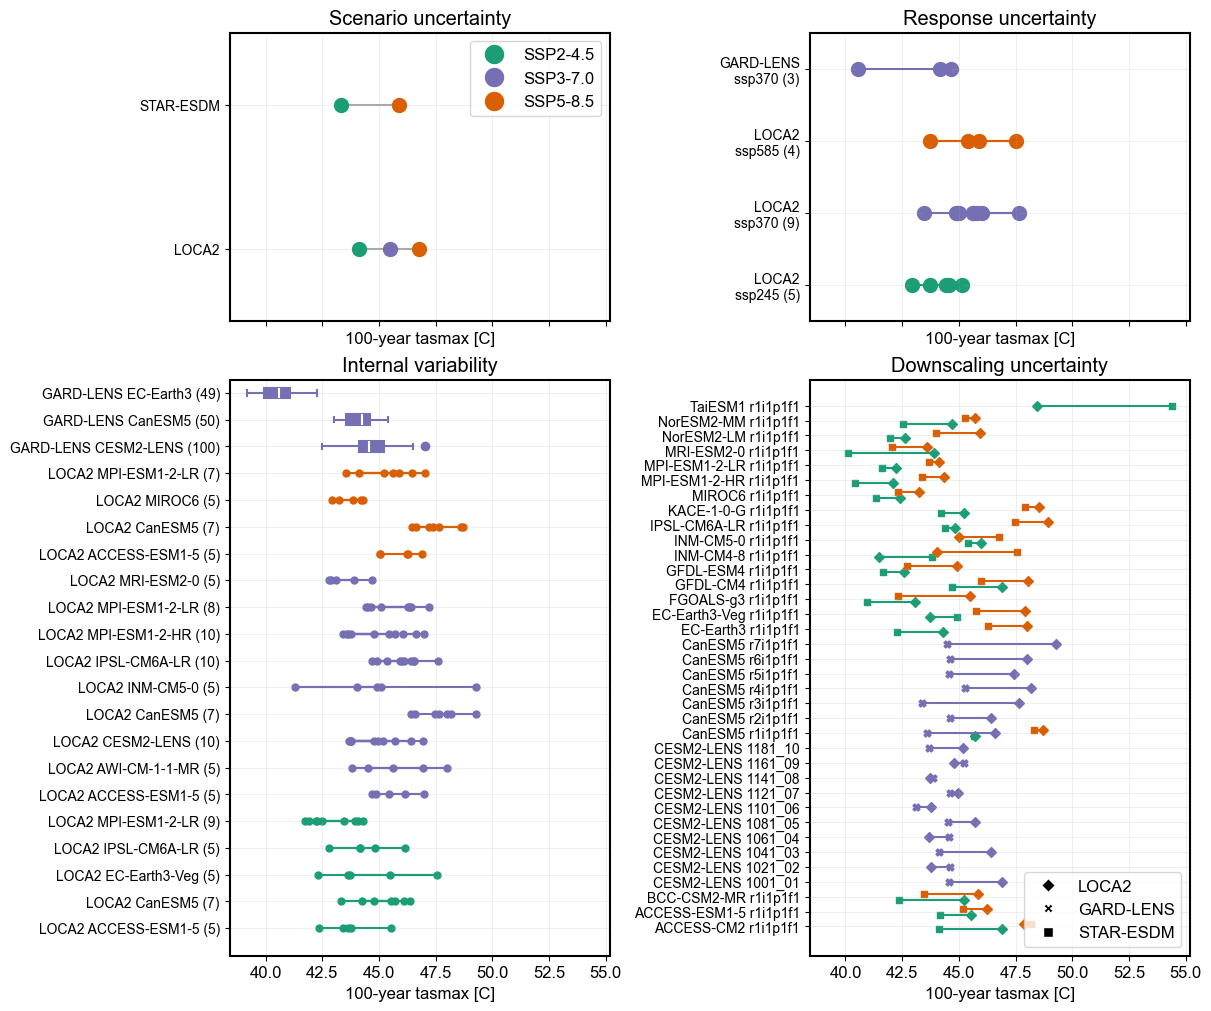

In [5]:
# Read all
metric_id = 'max_tasmax'
xlabel = "100-year tasmax [C]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)

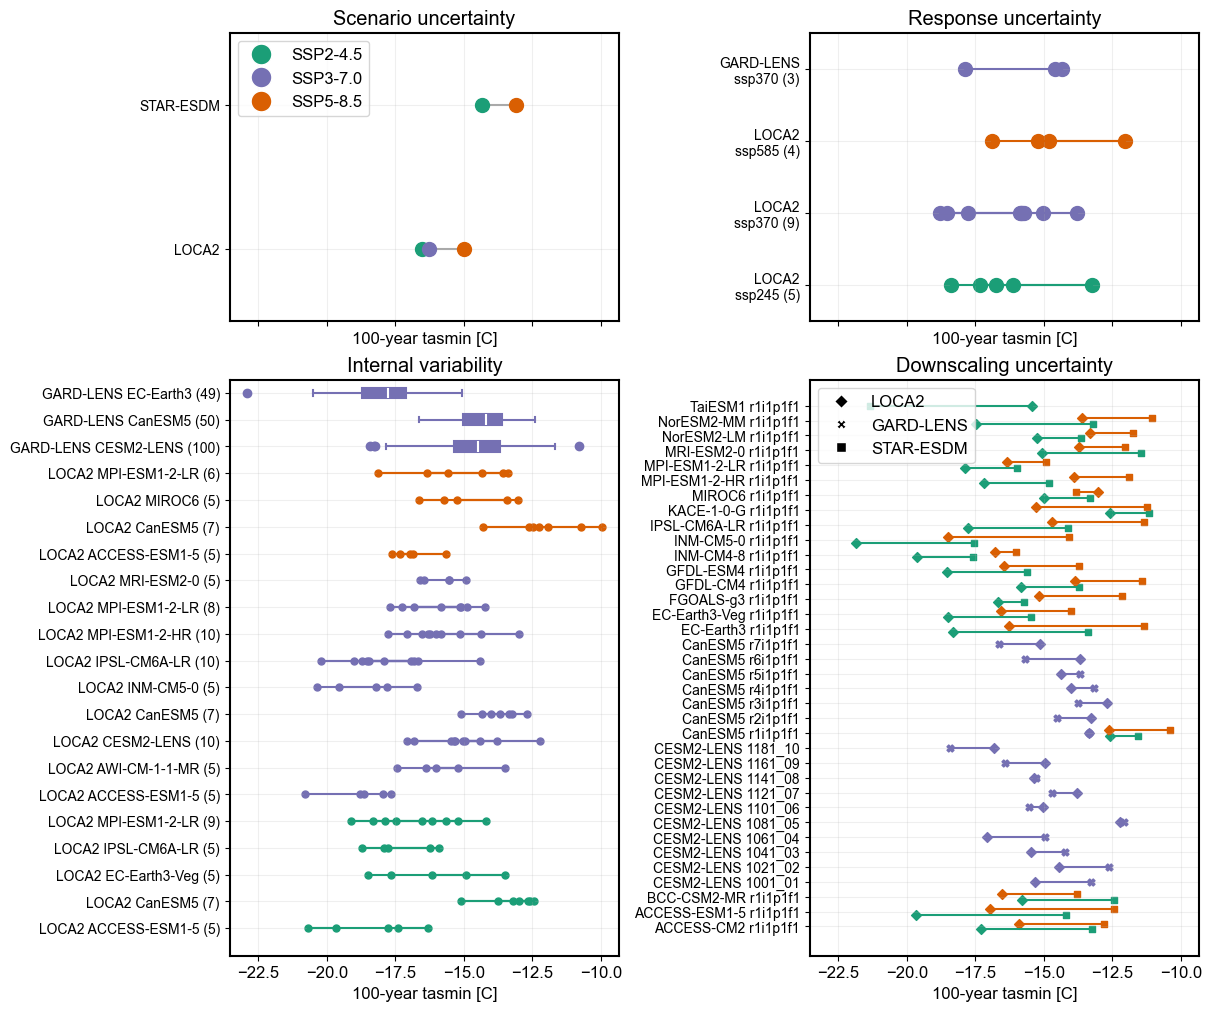

In [6]:
# Read all
metric_id = 'min_tasmin'
xlabel = "100-year tasmin [C]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)

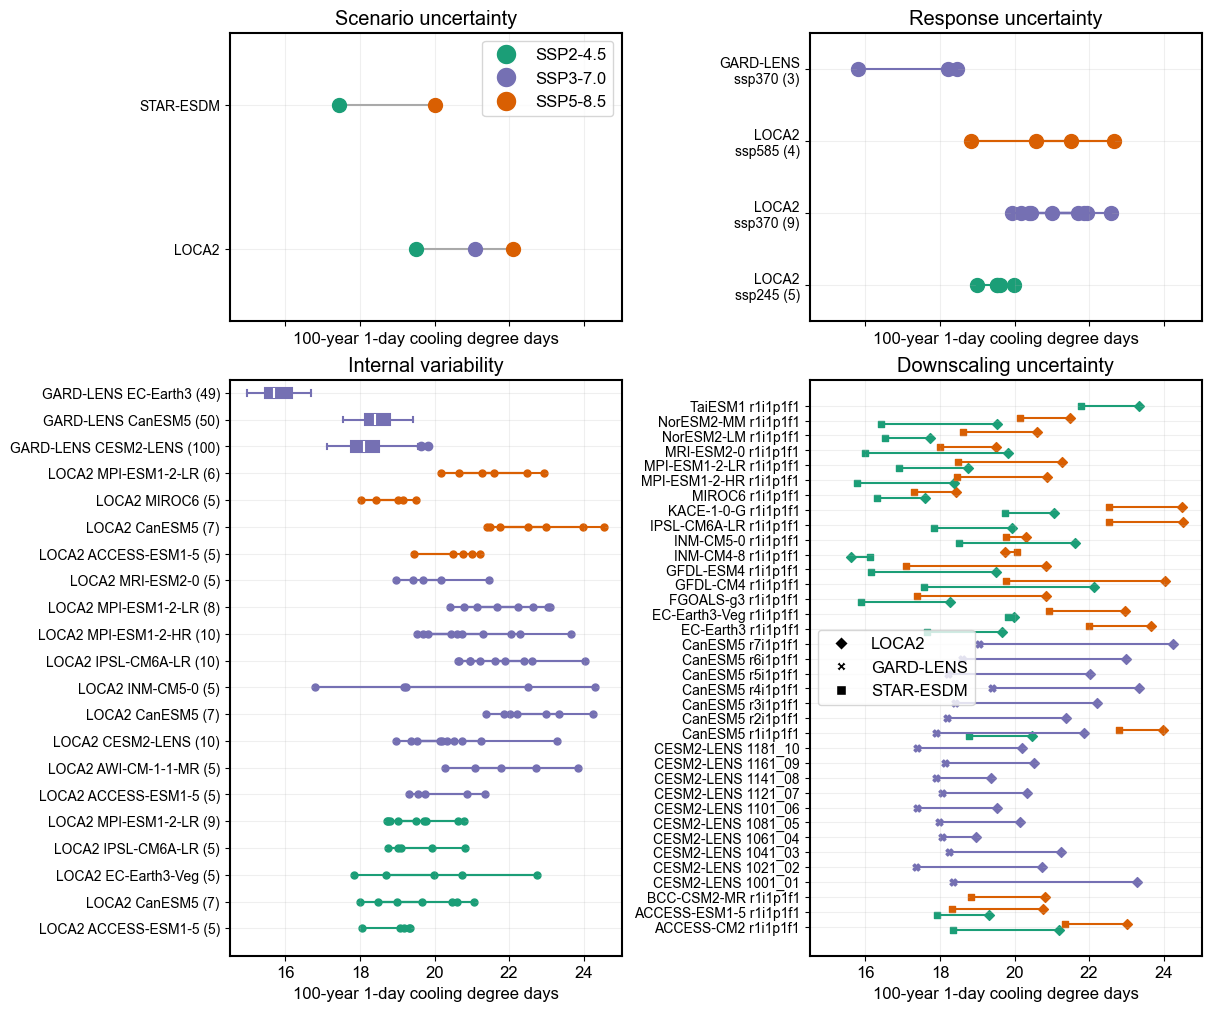

In [7]:
# Read all
metric_id = 'max_cdd'
xlabel = "100-year 1-day cooling degree days"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)

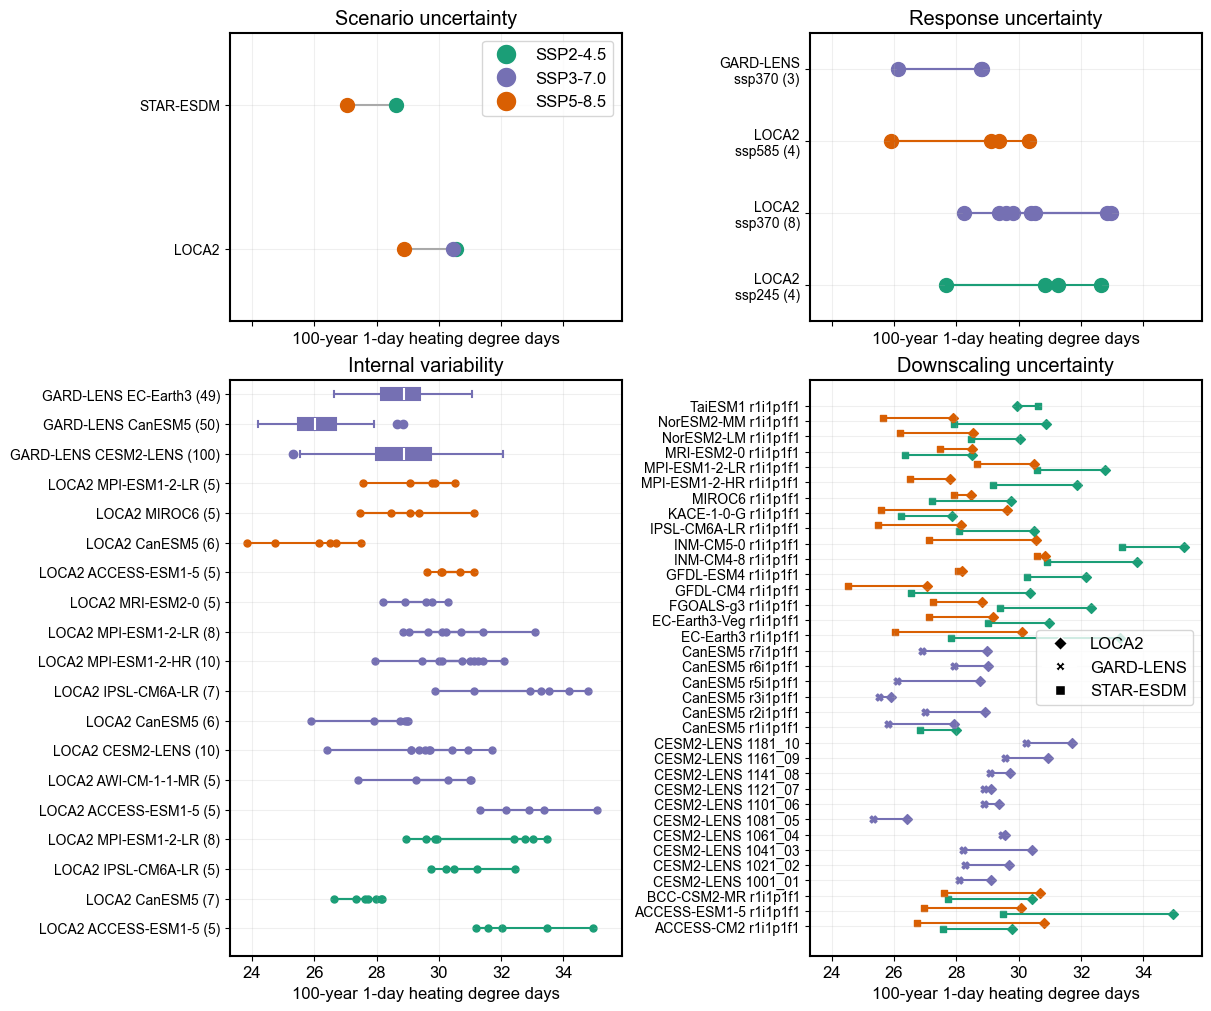

In [8]:
# Read all
metric_id = 'max_hdd'
xlabel = "100-year 1-day heating degree days"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)

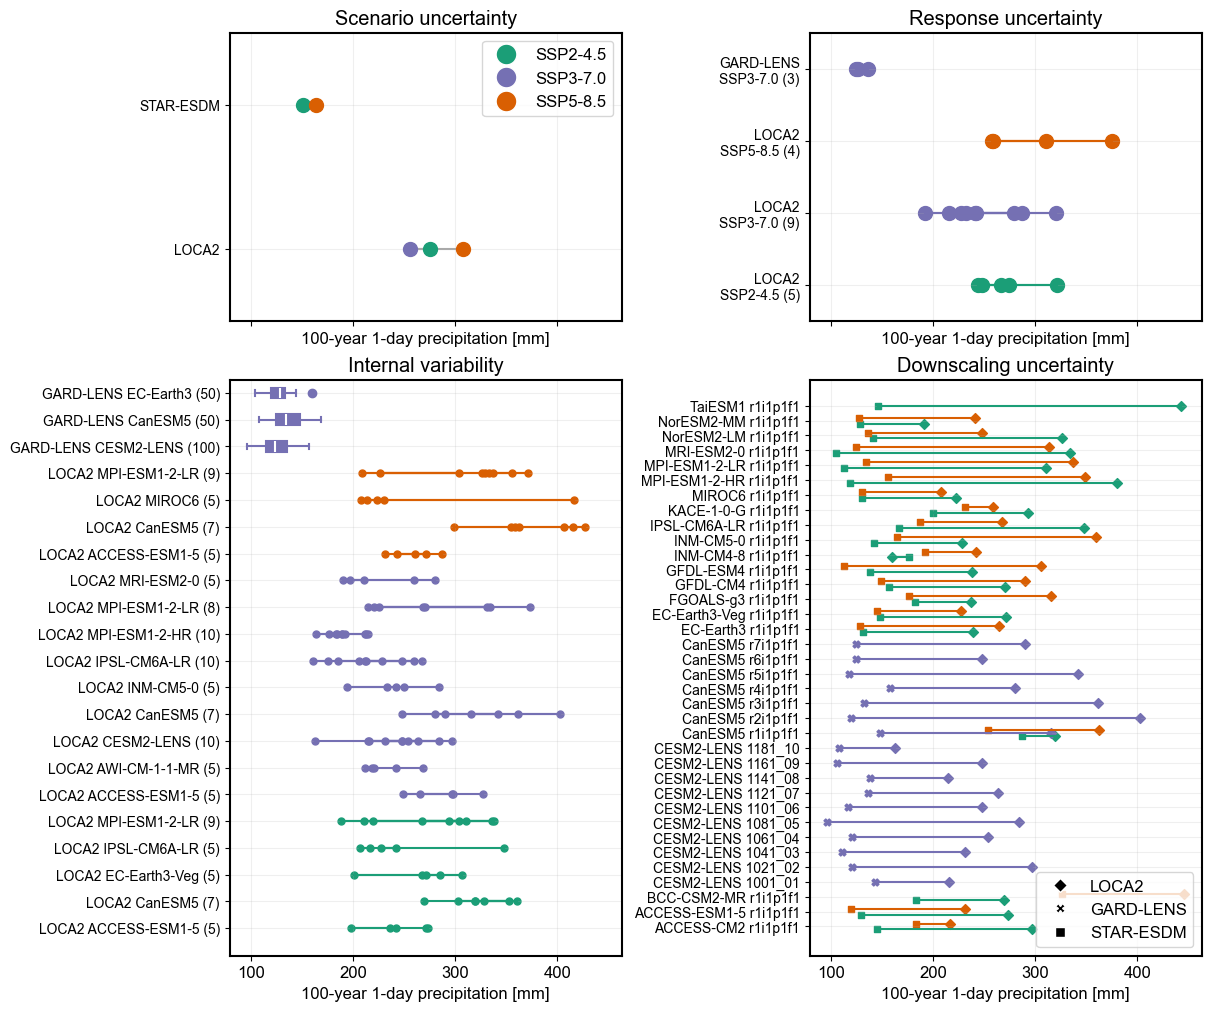

In [13]:
# Read all
metric_id = 'max_pr'
xlabel = "100-year 1-day precipitation [mm]"
regrid_method = 'nearest'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
return_period = 100

# Read
city = 'nyc'
file_name = f"{city}_{metric_id}_{proj_slice}_{hist_slice}_{return_period}rl_{regrid_method}.csv"
df_all = pd.read_csv(f"{project_data_path}/extreme_value/cities/loca_grid/{file_name}")

# Plot
plot_col = "100yr_return_level"

pu.plot_decomp_qual(df = df_all[df_all['ssp'] != 'historical'],
                 plot_col = plot_col,
                 xlabel = xlabel)